In [15]:
from generator_prevbit import make_train_test
import numpy as np
from hippo import hippo_legs, discretize_bilinear
from helpers import sigmoid, binary_cross_entropy
from model_2 import SimpleSSM
import matplotlib.pyplot as plt

from Training.generator_prevbit import make_train_test
import numpy as np
from SSM.hippo import hippo_legs, discretize_bilinear
from SSM.helpers import sigmoid, binary_cross_entropy
from SSM.model import SimpleSSM
import matplotlib.pyplot as plt

In [16]:
# Generate data

# Size of data matters alot, especially for how simple the task is. If the training data is very large, then the model will learn it within one epoch and the average loss will be small even on the first pass
x_train, y_train, x_test, y_test = make_train_test(
    n_train=100,
    n_test=10,
    T=10,
    seed=0,
)

In [17]:
model = SimpleSSM(state_dim=8, input_dim=1, output_dim=1)
num_epochs = 100
learning_rate = 1e-2


In [18]:
from helpers import sigmoid  # or your sigmoid

u = x_train[0]            # (T,1)
t = y_train[0]            # (T,1)
logits, _ = model.forward(u)
#print(logits)
probs = sigmoid(logits)

eps = 1e-8
loss_manual = -np.mean(
    t * np.log(probs + eps) +
    (1 - t) * np.log(1 - probs + eps)
)
print("manual BCE on first sequence:", loss_manual)

loss, _ = model.loss_and_grads(u, t)
print("loss_and_grads loss:", loss)


manual BCE on first sequence: 0.693127495054777
loss_and_grads loss: 0.693127495054777


In [19]:
print(model.A_ct)
print(model.A)
los = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i in range(x_train.shape[0]):
        u = x_train[i]      # shape (T,1)
        tgt = y_train[i]    # shape (T,1)

        loss, grads = model.loss_and_grads(u, tgt)
        

        
        model.step(grads, lr=learning_rate)
        epoch_loss += loss
    los.append(epoch_loss / x_train.shape[0])
    print(f"epoch {epoch} | avg loss = {epoch_loss / x_train.shape[0]}")

print(model.A)

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
[[ 3.33333333e-01 -3.37864825e-16 -2.06854932e-16  1.93156033e-16
   1.87791344e-16 -6.85528257e-17 -3.86372710e-16 -2.22044605e-16]
 [-5.77350269e-01  3.90787006e-16 

In [9]:

print(model.forward(x_train[0])[0])

[[-1.64866215]
 [ 8.61597401]
 [ 7.94895257]
 ...
 [ 5.71134384]
 [-6.58245681]
 [ 4.44494301]]


In [133]:
from generator_prevbit import make_prev_bit_example

#prev_bit vs memory
#as you increase sequence length
#the logits increase in magniute with memroy, logits stay witin their magnitues with prev_bit
#the hidden state components increase slowly with prev_bit and dont' increase much in magntiude, the hiddden state componente increase a lot quicker since they increase in magnitude in memory


#prev_bit = shows why hippo is better than rnadom and specific properties within hippo
    #also shows that since A doesn't need to remmeber much in the past, stuff doesn't explode there
    

#memory = shows that since A needs to remember lots in in the past, stuff does explode there compared to prev_bit

#the differecnes in how quickly the hidden state and the logits increase in magniutde between memerouy and prev_bit
#shows that if A doesn't need to remember much in the past, rescuriveve trainign does well, but if
#if it needs to remember stuff in teh past, logits and hidden states start to increase in magnitude which contributes
#towards the loss function eventually starting to increase, evne with very low learning rate

#what seperates ssm from rnn in this regards (when needing to remember information from many sequences ago,
#is that ssms are linear and could be trained convolutionally --> we did not experiment with this


a, b = make_prev_bit_example(5)

print(a, b)
print([1,2,3,4][:-1])

[[1.]
 [1.]
 [1.]
 [0.]
 [1.]] [[1.]
 [1.]
 [1.]
 [1.]
 [0.]]
[1, 2, 3]


In [28]:
# Testing ERror
print("mean of y_train:", y_train.mean())
print("min target:", y_train.min(), "max target:", y_train.max())
print("mean target over all train data:", y_train.mean())

u = x_train[0].reshape(-1)
t = y_train[0].reshape(-1)
print("input:  ", u.astype(int).tolist())
print("target: ", t.astype(int).tolist())

import numpy as np
eps = 1e-8
p = 0.01
y = y_train.reshape(-1)   # flatten all targets

baseline_loss = -np.mean(
    y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)
)

print("baseline constant-p loss:", baseline_loss)

mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
baseline constant-p loss: 2.4408682028173887


Text(0.5, 1.0, 'hippo')

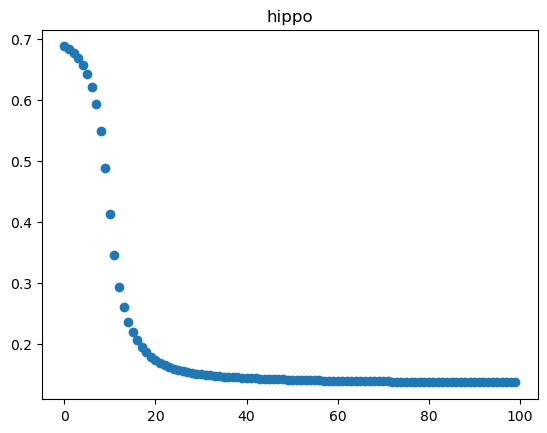

In [20]:
import matplotlib.pyplot as plt

plt.scatter([i for i in range(num_epochs)], los)
plt.title('hippo')

In [28]:
for i in range(21):
    u = x_test[i]
    tgt = y_test[i]
    logits, _ = model.forward(u)
    probs = sigmoid(logits)
    print('#############')
    print((probs > 0.5).astype(int))
    print(tgt)
    print('####################')

#############
[[1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]]
[[1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]]
####################
#############
[[0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]]
####################
#############
[[0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]]
[[0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]]
####################
#############
[[0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]]
[[0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]
####################
#############
[[1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]]
[[1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]
####################
#############
[[0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]]
[[0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]]
####################
#############
[[0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]]
[[0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]

IndexError: index 10 is out of bounds for axis 0 with size 10

In [25]:
N = x_test.shape[0]
total_loss = 0.0
total_correct = 0
total_bits = 0

for i in range(N):
    u = x_test[i]      # (T, 1)
    tgt = y_test[i]    # (T, 1)
    

    # forward pass only (no grads)
    logits, _ = model.forward(u)

    # loss for this sequence
    loss = binary_cross_entropy(logits, tgt)
    total_loss += loss

    # compute accuracy for this sequence
    probs = sigmoid(logits)
    preds = (probs > 0.5).astype(int)   # threshold at 0.5

    print('\n\n')

    total_correct += (preds == tgt).sum()
    total_bits += tgt.size

avg_loss = total_loss / N
accuracy = total_correct / total_bits

print(avg_loss)
print(accuracy)































0.13736903308766374
0.94


*padding first row*

In [48]:
model.A_ct[0] = [0]*model.A_ct.shape[1]
print(model.A_ct)

[[  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]


In [33]:
u = x_train[0]            # (T,1)
t = y_train[0]            # (T,1)
logits, _ = model.forward(u)
probs = sigmoid(logits)

eps = 1e-8
loss_manual = -np.mean(
    t * np.log(probs + eps) +
    (1 - t) * np.log(1 - probs + eps)
)
print("manual BCE on first sequence:", loss_manual)

loss, _ = model.loss_and_grads(u, t)
print("loss_and_grads loss:", loss)


los = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i in range(x_train.shape[0]):
        u = x_train[i]      # shape (T,1)
        tgt = y_train[i]    # shape (T,1)

        loss, grads = model.loss_and_grads(u, tgt)
        

        
        model.step(grads, lr=learning_rate)
        epoch_loss += loss
    los.append(epoch_loss / x_train.shape[0])
    #print(f"epoch {epoch} | avg loss = {epoch_loss / x_train.shape[0]}")

# Testing ERror
print("mean of y_train:", y_train.mean())
print("min target:", y_train.min(), "max target:", y_train.max())
print("mean target over all train data:", y_train.mean())

u = x_train[0].reshape(-1)
t = y_train[0].reshape(-1)
print("input:  ", u.astype(int).tolist())
print("target: ", t.astype(int).tolist())

import numpy as np
eps = 1e-8
p = 0.01
y = y_train.reshape(-1)   # flatten all targets

baseline_loss = -np.mean(
    y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)
)

print("baseline constant-p loss:", baseline_loss)





N = x_test.shape[0]
total_loss = 0.0
total_correct = 0
total_bits = 0

for i in range(N):
    u = x_test[i]      # (T, 1)
    tgt = y_test[i]    # (T, 1)

    # forward pass only (no grads)
    logits, _ = model.forward(u)

    # loss for this sequence
    loss = binary_cross_entropy(logits, tgt)
    total_loss += loss

    # compute accuracy for this sequence
    probs = sigmoid(logits)
    preds = (probs > 0.5).astype(int)   # threshold at 0.5
    total_correct += (preds == tgt).sum()
    total_bits += tgt.size

avg_loss = total_loss / N
accuracy = total_correct / total_bits

print(avg_loss)
print(accuracy)



manual BCE on first sequence: 0.09801126887904024
loss_and_grads loss: 0.09801126887904024
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
baseline constant-p loss: 2.4408682028173887
0.13437329142084797
0.94


In [36]:
model = SimpleSSM(state_dim=8, input_dim=1, output_dim=1)
model.A_ct[1] = [0]*model.A_ct.shape[1]
for i in (model.A_ct):
    print(i)

[-1.  0.  0.  0.  0.  0.  0.  0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[-2.23606798 -3.87298335 -3.          0.          0.          0.
  0.          0.        ]
[-2.64575131 -4.58257569 -5.91607978 -4.          0.          0.
  0.          0.        ]
[-3.         -5.19615242 -6.70820393 -7.93725393 -5.          0.
  0.          0.        ]
[-3.31662479 -5.74456265 -7.41619849 -8.77496439 -9.94987437 -6.
  0.          0.        ]
[ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
 -11.95826074  -7.           0.        ]
[ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
 -12.84523258 -13.96424004  -8.        ]


In [35]:
u = x_train[0]            # (T,1)
t = y_train[0]            # (T,1)
logits, _ = model.forward(u)
probs = sigmoid(logits)

eps = 1e-8
loss_manual = -np.mean(
    t * np.log(probs + eps) +
    (1 - t) * np.log(1 - probs + eps)
)
print("manual BCE on first sequence:", loss_manual)

loss, _ = model.loss_and_grads(u, t)
print("loss_and_grads loss:", loss)


los = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i in range(x_train.shape[0]):
        u = x_train[i]      # shape (T,1)
        tgt = y_train[i]    # shape (T,1)

        loss, grads = model.loss_and_grads(u, tgt)
        

        
        model.step(grads, lr=learning_rate)
        epoch_loss += loss
    los.append(epoch_loss / x_train.shape[0])
    #print(f"epoch {epoch} | avg loss = {epoch_loss / x_train.shape[0]}")

# Testing ERror
print("mean of y_train:", y_train.mean())
print("min target:", y_train.min(), "max target:", y_train.max())
print("mean target over all train data:", y_train.mean())

u = x_train[0].reshape(-1)
t = y_train[0].reshape(-1)
print("input:  ", u.astype(int).tolist())
print("target: ", t.astype(int).tolist())

import numpy as np
eps = 1e-8
p = 0.01
y = y_train.reshape(-1)   # flatten all targets

baseline_loss = -np.mean(
    y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)
)

print("baseline constant-p loss:", baseline_loss)





N = x_test.shape[0]
total_loss = 0.0
total_correct = 0
total_bits = 0

for i in range(N):
    u = x_test[i]      # (T, 1)
    tgt = y_test[i]    # (T, 1)

    # forward pass only (no grads)
    logits, _ = model.forward(u)

    # loss for this sequence
    loss = binary_cross_entropy(logits, tgt)
    total_loss += loss

    # compute accuracy for this sequence
    probs = sigmoid(logits)
    preds = (probs > 0.5).astype(int)   # threshold at 0.5
    total_correct += (preds == tgt).sum()
    total_bits += tgt.size

avg_loss = total_loss / N
accuracy = total_correct / total_bits

print(avg_loss)
print(accuracy)



manual BCE on first sequence: 0.693127495054777
loss_and_grads loss: 0.693127495054777
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
baseline constant-p loss: 2.4408682028173887
0.13736903308766374
0.94


[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
[ 3.33333333e-01  3.02062103e-17  1.72461633e-16  8.35657954e-16
 -2.08229983e-16 -4.70832360e-16 -4.36720598e-16 -1.71995011e-16]
[-5.77350269e-01  4.23212065e-16  2.

manual BCE on first sequence: 0.6929511059046828
loss_and_grads loss: 0.6929511059046828
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
baseline constant-p loss: 2.4408682028173887
0.1371860267279404
0.94


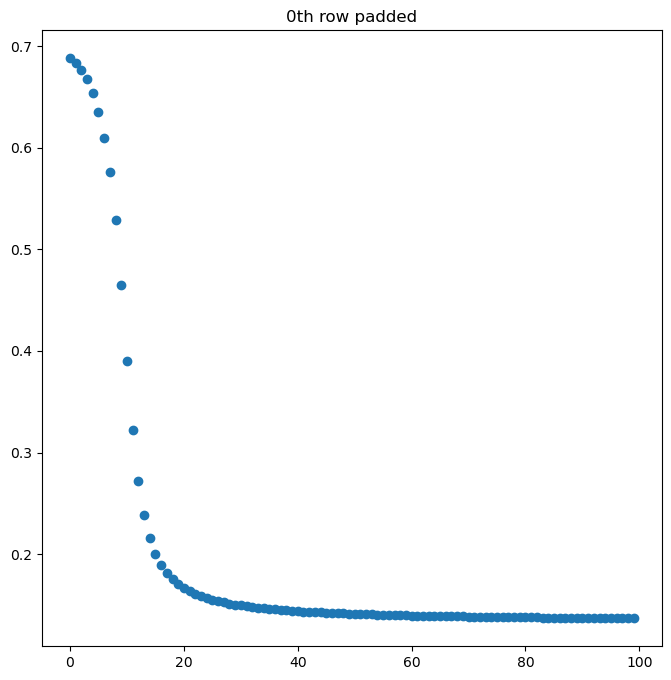

manual BCE on first sequence: 0.6921658643950995
loss_and_grads loss: 0.6921658643950995
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
baseline constant-p loss: 2.4408682028173887
0.1375632775731264
0.94


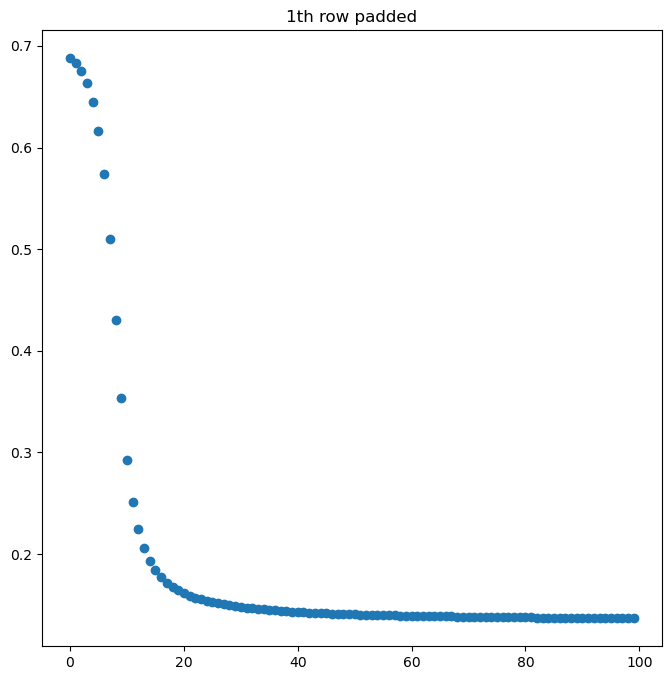

manual BCE on first sequence: 0.6790929138659586
loss_and_grads loss: 0.6790929138659586
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
baseline constant-p loss: 2.4408682028173887
0.13675539020339397
0.94


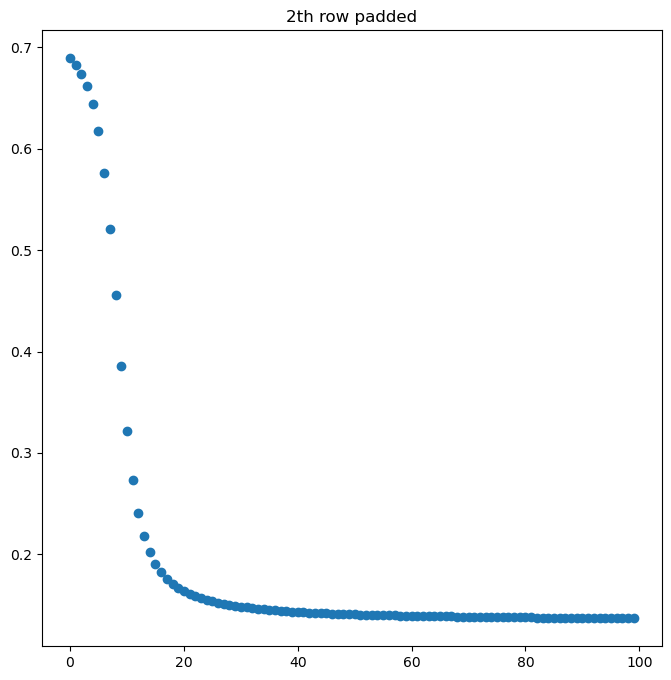

manual BCE on first sequence: 0.6935810756197011
loss_and_grads loss: 0.6935810756197011
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
baseline constant-p loss: 2.4408682028173887
0.13628991384716455
0.94


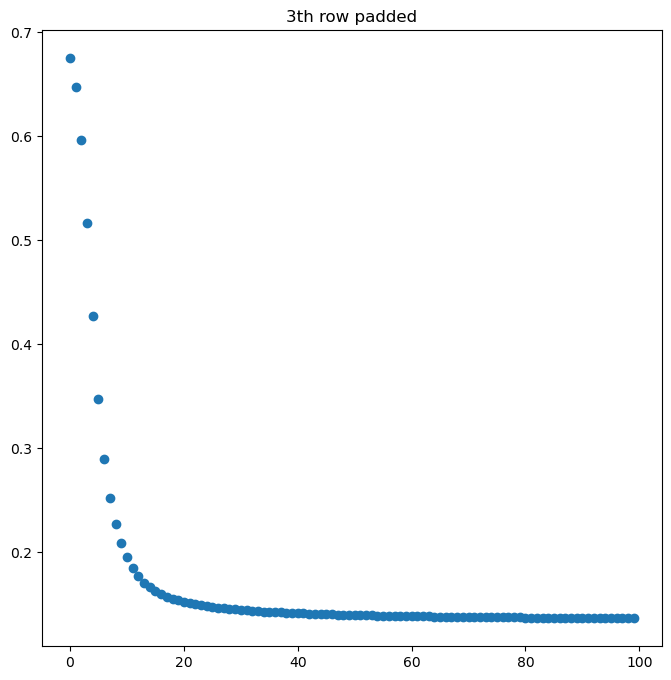

manual BCE on first sequence: 0.701235311819963
loss_and_grads loss: 0.701235311819963
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
baseline constant-p loss: 2.4408682028173887
0.13648040295836894
0.94


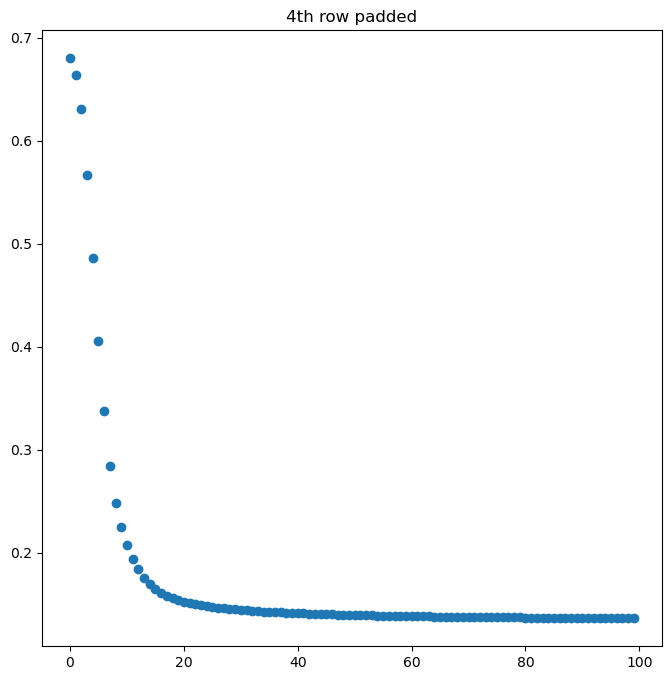

manual BCE on first sequence: 0.6949883287574042
loss_and_grads loss: 0.6949883287574042
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
baseline constant-p loss: 2.4408682028173887
0.13645499998372163
0.94


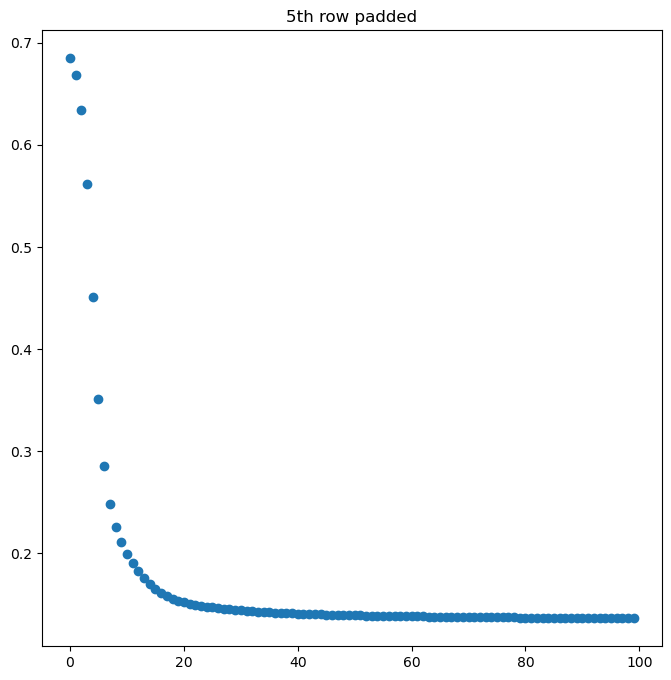

manual BCE on first sequence: 0.6938499452521033
loss_and_grads loss: 0.6938499452521033
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
baseline constant-p loss: 2.4408682028173887
0.13655853514202354
0.94


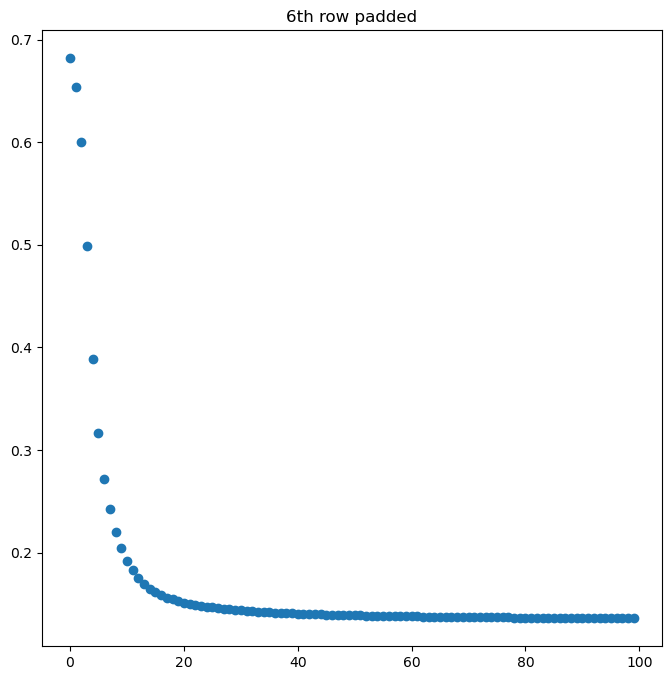

manual BCE on first sequence: 0.6899047953125348
loss_and_grads loss: 0.6899047953125348
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
baseline constant-p loss: 2.4408682028173887
0.1376209647971406
0.94


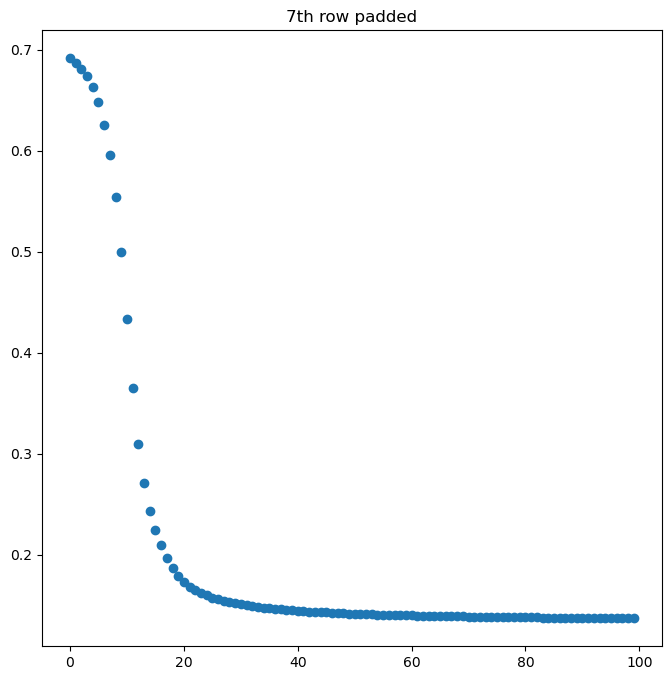

In [90]:



for j in range(8):
    plt.figure(figsize = (8,8))
    model = SimpleSSM(state_dim=8, input_dim=1, output_dim=1)
    model.A_ct[j] = [0]*model.A_ct.shape[1]
    #print(model.A_ct)
    model.A = discretize_bilinear(model.A_ct, dt=model.dt)

    u = x_train[0]            # (T,1)
    t = y_train[0]            # (T,1)
    logits, _ = model.forward(u)
    #print(logits)
    probs = sigmoid(logits)

    eps = 1e-8
    loss_manual = -np.mean(
        t * np.log(probs + eps) +
        (1 - t) * np.log(1 - probs + eps)
    )
    print("manual BCE on first sequence:", loss_manual)

    loss, _ = model.loss_and_grads(u, t)
    print("loss_and_grads loss:", loss)


    los = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i in range(x_train.shape[0]):
            u = x_train[i]      # shape (T,1)
            tgt = y_train[i]    # shape (T,1)

            loss, grads = model.loss_and_grads(u, tgt)
        

        
            model.step(grads, lr=learning_rate)
            epoch_loss += loss
        los.append(epoch_loss / x_train.shape[0])
        #print(f"epoch {epoch} | avg loss = {epoch_loss / x_train.shape[0]}")

    # Testing ERror
    print("mean of y_train:", y_train.mean())
    print("min target:", y_train.min(), "max target:", y_train.max())
    print("mean target over all train data:", y_train.mean())

    u = x_train[0].reshape(-1)
    t = y_train[0].reshape(-1)
    print("input:  ", u.astype(int).tolist())
    print("target: ", t.astype(int).tolist())


    eps = 1e-8
    p = 0.01
    y = y_train.reshape(-1)   # flatten all targets

    baseline_loss = -np.mean(
        y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)
    )

    print("baseline constant-p loss:", baseline_loss)





    N = x_test.shape[0]
    total_loss = 0.0
    total_correct = 0
    total_bits = 0

    for i in range(N):
        u = x_test[i]      # (T, 1)
        tgt = y_test[i]    # (T, 1)

        # forward pass only (no grads)
        logits, _ = model.forward(u)

        # loss for this sequence
        loss = binary_cross_entropy(logits, tgt)
        total_loss += loss

        # compute accuracy for this sequence
        probs = sigmoid(logits)
        preds = (probs > 0.5).astype(int)   # threshold at 0.5
        total_correct += (preds == tgt).sum()
        total_bits += tgt.size

    avg_loss = total_loss / N
    accuracy = total_correct / total_bits

    print(avg_loss)
    print(accuracy)
    plt.scatter([i for i in range(num_epochs)], los)
    plt.title(f'{j}th row padded')


   
    plt.show()

[[  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004   0.        ]]
manual BCE on first sequence: 0.6978459060578873
loss_and_grads loss: 0.6978459060578873
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

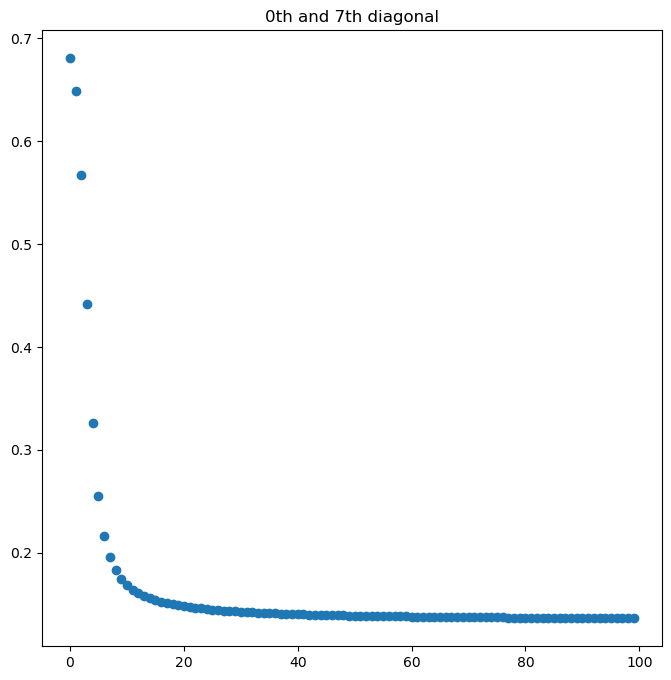

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081   0.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074   0.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.6903436214578349
loss_and_grads loss: 0.6903436214578349
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

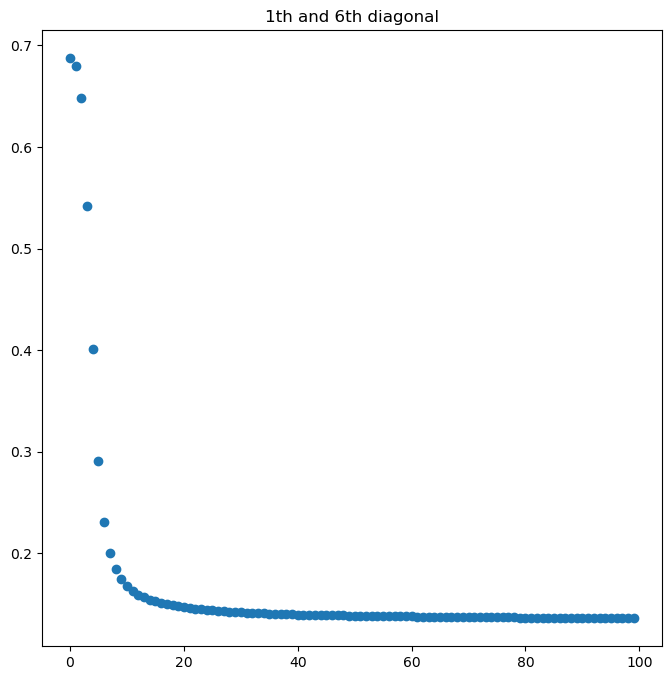

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335   0.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
    0.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.5613361687666181
loss_and_grads loss: 0.5613361687666181
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

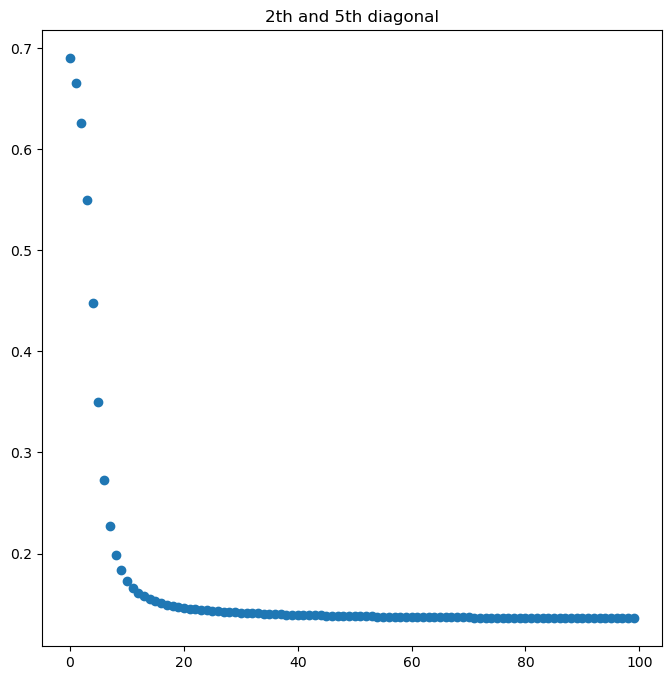

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978   0.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393   0.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.39356224813037777
loss_and_grads loss: 0.39356224813037777
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all 

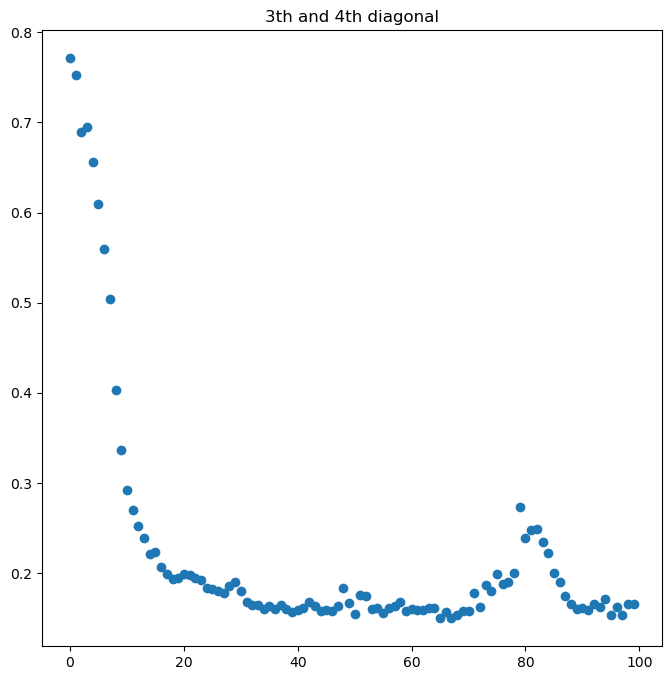

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978   0.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393   0.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.39356224813037777
loss_and_grads loss: 0.39356224813037777
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all 

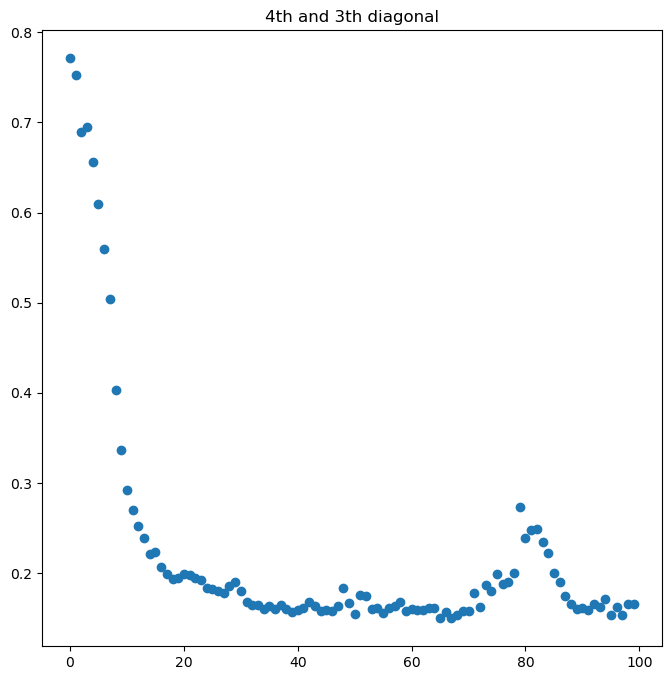

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335   0.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
    0.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.5613361687666181
loss_and_grads loss: 0.5613361687666181
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

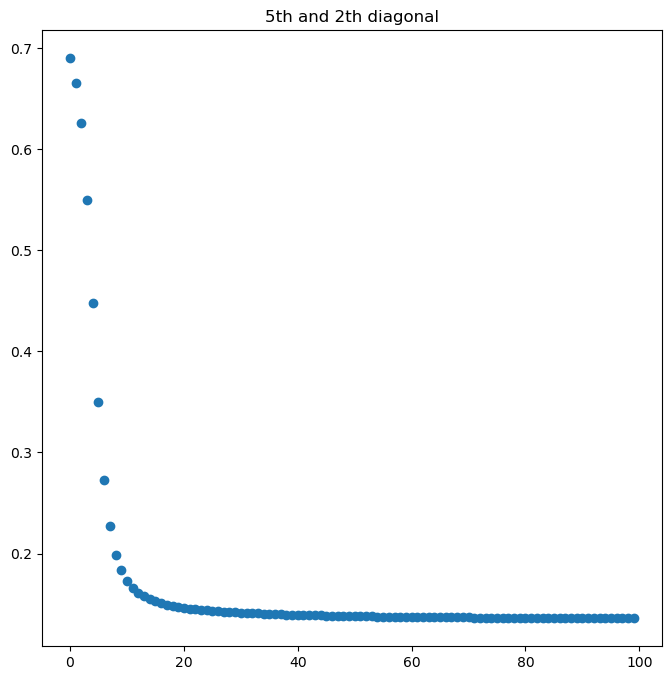

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081   0.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074   0.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.6903436214578349
loss_and_grads loss: 0.6903436214578349
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

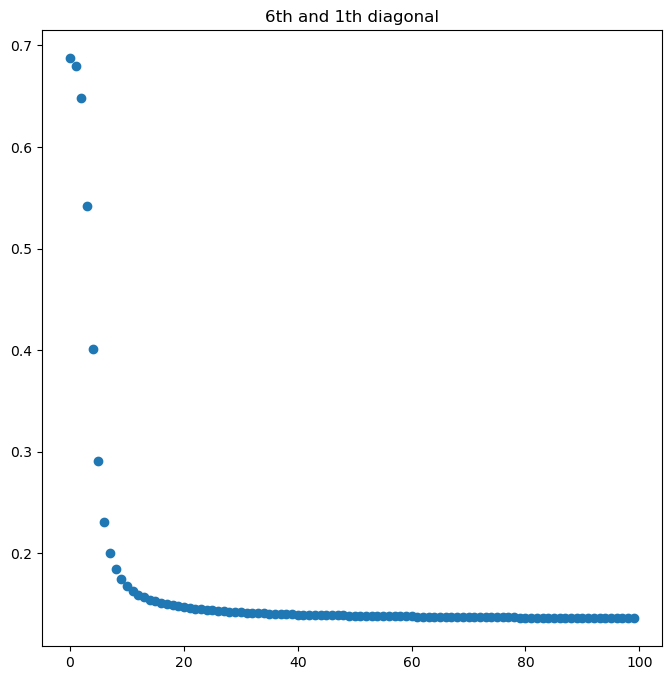

In [12]:



for j in range(7):
    plt.figure(figsize = (8,8))
    model = SimpleSSM(state_dim=8, input_dim=1, output_dim=1)
    model.A_ct[0+j][0+j] = 0
    model.A_ct[model.A_ct.shape[0]-1-j][model.A_ct.shape[0]-1-j] = 0
    print(model.A_ct)
    model.A = discretize_bilinear(model.A_ct, dt=model.dt)

    u = x_train[0]            # (T,1)
    t = y_train[0]            # (T,1)
    logits, _ = model.forward(u)
    #print(logits)
    probs = sigmoid(logits)

    eps = 1e-8
    loss_manual = -np.mean(
        t * np.log(probs + eps) +
        (1 - t) * np.log(1 - probs + eps)
    )
    print("manual BCE on first sequence:", loss_manual)

    loss, _ = model.loss_and_grads(u, t)
    print("loss_and_grads loss:", loss)


    los = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i in range(x_train.shape[0]):
            u = x_train[i]      # shape (T,1)
            tgt = y_train[i]    # shape (T,1)

            loss, grads = model.loss_and_grads(u, tgt)
        

        
            model.step(grads, lr=learning_rate)
            epoch_loss += loss
        los.append(epoch_loss / x_train.shape[0])
        #print(f"epoch {epoch} | avg loss = {epoch_loss / x_train.shape[0]}")

    # Testing ERror
    print("mean of y_train:", y_train.mean())
    print("min target:", y_train.min(), "max target:", y_train.max())
    print("mean target over all train data:", y_train.mean())

    u = x_train[0].reshape(-1)
    t = y_train[0].reshape(-1)
    print("input:  ", u.astype(int).tolist())
    print("target: ", t.astype(int).tolist())


    eps = 1e-8
    p = 0.01
    y = y_train.reshape(-1)   # flatten all targets

    baseline_loss = -np.mean(
        y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)
    )

    print("baseline constant-p loss:", baseline_loss)





    N = x_test.shape[0]
    total_loss = 0.0
    total_correct = 0
    total_bits = 0

    for i in range(N):
        u = x_test[i]      # (T, 1)
        tgt = y_test[i]    # (T, 1)

        # forward pass only (no grads)
        logits, _ = model.forward(u)

        # loss for this sequence
        loss = binary_cross_entropy(logits, tgt)
        total_loss += loss

        # compute accuracy for this sequence
        probs = sigmoid(logits)
        preds = (probs > 0.5).astype(int)   # threshold at 0.5
        total_correct += (preds == tgt).sum()
        total_bits += tgt.size

    avg_loss = total_loss / N
    accuracy = total_correct / total_bits

    print(avg_loss)
    print(accuracy)
    plt.scatter([i for i in range(num_epochs)], los)
    plt.title(f'{j}th and {7-j}th diagonal')


   
    plt.show()

[[  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081   0.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335   0.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978   0.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393   0.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
    0.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074   0.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 3.110963724470633
loss_and_grads loss: 3.110963724470633


/Users/admin/Desktop/phy_329/ssm/helpers.py:4: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
baseline constant-p loss: 2.4408682028173887
4.7677926766159935
0.62


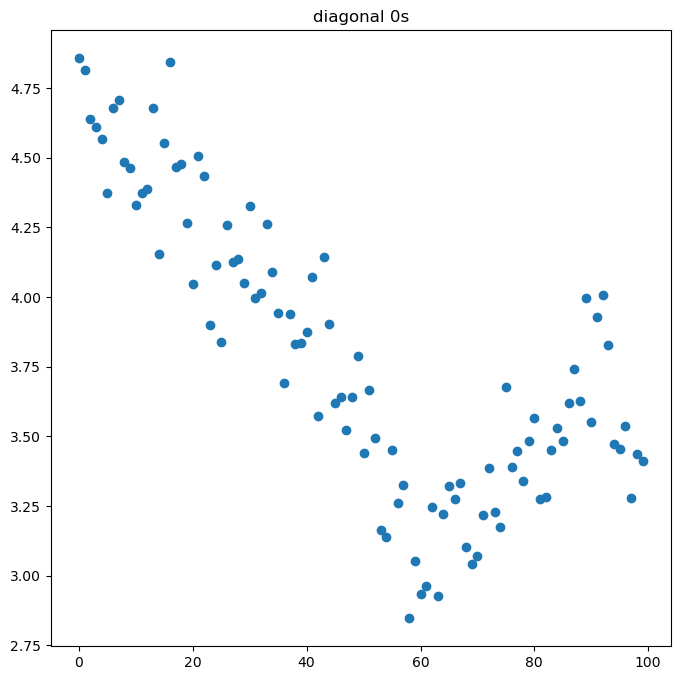

In [95]:



for j in range(1):
    plt.figure(figsize = (8,8))
    model = SimpleSSM(state_dim=8, input_dim=1, output_dim=1)
    for z in range(7):
        model.A_ct[0+z][0+z] = 0
    
    print(model.A_ct)
    model.A = discretize_bilinear(model.A_ct, dt=model.dt)

    u = x_train[0]            # (T,1)
    t = y_train[0]            # (T,1)
    logits, _ = model.forward(u)
    #print(logits)
    probs = sigmoid(logits)

    eps = 1e-8
    loss_manual = -np.mean(
        t * np.log(probs + eps) +
        (1 - t) * np.log(1 - probs + eps)
    )
    print("manual BCE on first sequence:", loss_manual)

    loss, _ = model.loss_and_grads(u, t)
    print("loss_and_grads loss:", loss)


    los = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i in range(x_train.shape[0]):
            u = x_train[i]      # shape (T,1)
            tgt = y_train[i]    # shape (T,1)

            loss, grads = model.loss_and_grads(u, tgt)
        

        
            model.step(grads, lr=learning_rate)
            epoch_loss += loss
        los.append(epoch_loss / x_train.shape[0])
        #print(f"epoch {epoch} | avg loss = {epoch_loss / x_train.shape[0]}")

    # Testing ERror
    print("mean of y_train:", y_train.mean())
    print("min target:", y_train.min(), "max target:", y_train.max())
    print("mean target over all train data:", y_train.mean())

    u = x_train[0].reshape(-1)
    t = y_train[0].reshape(-1)
    print("input:  ", u.astype(int).tolist())
    print("target: ", t.astype(int).tolist())


    eps = 1e-8
    p = 0.01
    y = y_train.reshape(-1)   # flatten all targets

    baseline_loss = -np.mean(
        y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)
    )

    print("baseline constant-p loss:", baseline_loss)





    N = x_test.shape[0]
    total_loss = 0.0
    total_correct = 0
    total_bits = 0

    for i in range(N):
        u = x_test[i]      # (T, 1)
        tgt = y_test[i]    # (T, 1)

        # forward pass only (no grads)
        logits, _ = model.forward(u)

        # loss for this sequence
        loss = binary_cross_entropy(logits, tgt)
        total_loss += loss

        # compute accuracy for this sequence
        probs = sigmoid(logits)
        preds = (probs > 0.5).astype(int)   # threshold at 0.5
        total_correct += (preds == tgt).sum()
        total_bits += tgt.size

    avg_loss = total_loss / N
    accuracy = total_correct / total_bits

    print(avg_loss)
    print(accuracy)
    plt.scatter([i for i in range(num_epochs)], los)
    plt.title(f'diagonal 0s')


   
    plt.show()

In [ ]:



for j in range(1):
    plt.figure(figsize = (8,8))
    model = SimpleSSM(state_dim=8, input_dim=1, output_dim=1)
    for z in range(5,8):
        for zz in range(5):
            model.A_ct[z][zz] = 0
    model.A_ct[6][5] = 0
    model.A_ct[7][5] = 0
    model.A_ct[7][6] = 0
    print(model.A_ct)
    model.A = discretize_bilinear(model.A_ct, dt=model.dt)

    u = x_train[0]            # (T,1)
    t = y_train[0]            # (T,1)
    logits, _ = model.forward(u)
    #print(logits)
    probs = sigmoid(logits)

    eps = 1e-8
    loss_manual = -np.mean(
        t * np.log(probs + eps) +
        (1 - t) * np.log(1 - probs + eps)
    )
    print("manual BCE on first sequence:", loss_manual)

    loss, _ = model.loss_and_grads(u, t)
    print("loss_and_grads loss:", loss)


    los = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i in range(x_train.shape[0]):
            u = x_train[i]      # shape (T,1)
            tgt = y_train[i]    # shape (T,1)

            loss, grads = model.loss_and_grads(u, tgt)
        

        
            model.step(grads, lr=learning_rate)
            epoch_loss += loss
        los.append(epoch_loss / x_train.shape[0])
        #print(f"epoch {epoch} | avg loss = {epoch_loss / x_train.shape[0]}")

    # Testing ERror
    print("mean of y_train:", y_train.mean())
    print("min target:", y_train.min(), "max target:", y_train.max())
    print("mean target over all train data:", y_train.mean())

    u = x_train[0].reshape(-1)
    t = y_train[0].reshape(-1)
    print("input:  ", u.astype(int).tolist())
    print("target: ", t.astype(int).tolist())


    eps = 1e-8
    p = 0.01
    y = y_train.reshape(-1)   # flatten all targets

    baseline_loss = -np.mean(
        y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)
    )

    print("baseline constant-p loss:", baseline_loss)





    N = x_test.shape[0]
    total_loss = 0.0
    total_correct = 0
    total_bits = 0

    for i in range(N):
        u = x_test[i]      # (T, 1)
        tgt = y_test[i]    # (T, 1)

        # forward pass only (no grads)
        logits, _ = model.forward(u)

        # loss for this sequence
        loss = binary_cross_entropy(logits, tgt)
        total_loss += loss

        # compute accuracy for this sequence
        probs = sigmoid(logits)
        preds = (probs > 0.5).astype(int)   # threshold at 0.5
        total_correct += (preds == tgt).sum()
        total_bits += tgt.size

    avg_loss = total_loss / N
    accuracy = total_correct / total_bits

    print(avg_loss)
    print(accuracy)
    plt.scatter([i for i in range(num_epochs)], los)
    plt.title(f'block of 0s')


   
    plt.show()

[[-1.          0.          0.          0.          0.          0.
   0.          0.        ]
 [-1.73205081 -2.          0.          0.          0.          0.
   0.          0.        ]
 [-2.23606798 -3.87298335 -3.          0.          0.          0.
   0.          0.        ]
 [-2.64575131 -4.58257569 -5.91607978 -4.          0.          0.
   0.          0.        ]
 [-3.         -5.19615242 -6.70820393 -7.93725393 -5.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.         -6.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -7.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         -8.        ]]
manual BCE on first sequence: 0.6909504251371396
loss_and_grads loss: 0.6909504251371396


[[-1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -2.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -3.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -4.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -5.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -6.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -7.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -8.]]
[[ 0.33333333  0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.         -0.2         0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.         -0.33333333  0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.         -0.42857143  0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.         -0.5
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -0.55555556  0.        ]
 [ 0.          0.          0.          0.          0.          0.
 

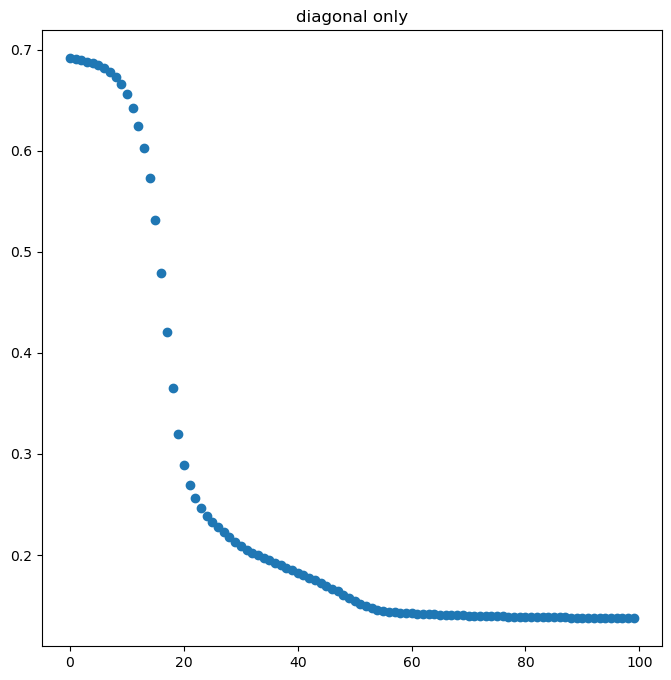

In [16]:



for j in range(1):
    plt.figure(figsize = (8,8))
    model = SimpleSSM(state_dim=8, input_dim=1, output_dim=1)
    for z in range(8):
        for zz in range(8):
            if z != zz:
                model.A_ct[z][zz] = 0
    
    print(model.A_ct)
    model.A = discretize_bilinear(model.A_ct, dt=model.dt)
    print(model.A)
    u = x_train[0]            # (T,1)
    t = y_train[0]            # (T,1)
    logits, _ = model.forward(u)
    #print(logits)
    probs = sigmoid(logits)

    eps = 1e-8
    loss_manual = -np.mean(
        t * np.log(probs + eps) +
        (1 - t) * np.log(1 - probs + eps)
    )
    print("manual BCE on first sequence:", loss_manual)

    loss, _ = model.loss_and_grads(u, t)
    print("loss_and_grads loss:", loss)


    los = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i in range(x_train.shape[0]):
            u = x_train[i]      # shape (T,1)
            tgt = y_train[i]    # shape (T,1)

            loss, grads = model.loss_and_grads(u, tgt)
        

        
            model.step(grads, lr=learning_rate)
            epoch_loss += loss
        los.append(epoch_loss / x_train.shape[0])
        #print(f"epoch {epoch} | avg loss = {epoch_loss / x_train.shape[0]}")

    # Testing ERror
    print("mean of y_train:", y_train.mean())
    print("min target:", y_train.min(), "max target:", y_train.max())
    print("mean target over all train data:", y_train.mean())

    u = x_train[0].reshape(-1)
    t = y_train[0].reshape(-1)
    print("input:  ", u.astype(int).tolist())
    print("target: ", t.astype(int).tolist())


    eps = 1e-8
    p = 0.01
    y = y_train.reshape(-1)   # flatten all targets

    baseline_loss = -np.mean(
        y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)
    )

    print("baseline constant-p loss:", baseline_loss)





    N = x_test.shape[0]
    total_loss = 0.0
    total_correct = 0
    total_bits = 0

    for i in range(N):
        u = x_test[i]      # (T, 1)
        tgt = y_test[i]    # (T, 1)

        # forward pass only (no grads)
        logits, _ = model.forward(u)

        # loss for this sequence
        loss = binary_cross_entropy(logits, tgt)
        total_loss += loss

        # compute accuracy for this sequence
        probs = sigmoid(logits)
        preds = (probs > 0.5).astype(int)   # threshold at 0.5
        total_correct += (preds == tgt).sum()
        total_bits += tgt.size

    avg_loss = total_loss / N
    accuracy = total_correct / total_bits

    print(avg_loss)
    print(accuracy)
    plt.scatter([i for i in range(num_epochs)], los)
    plt.title(f'diagonal only')


   
    plt.show()

[[  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081   0.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335   0.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
    0.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004   0.        ]]
manual BCE on first sequence: 7.0505070135132515
loss_and_grads loss: 7.0505070135132515
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

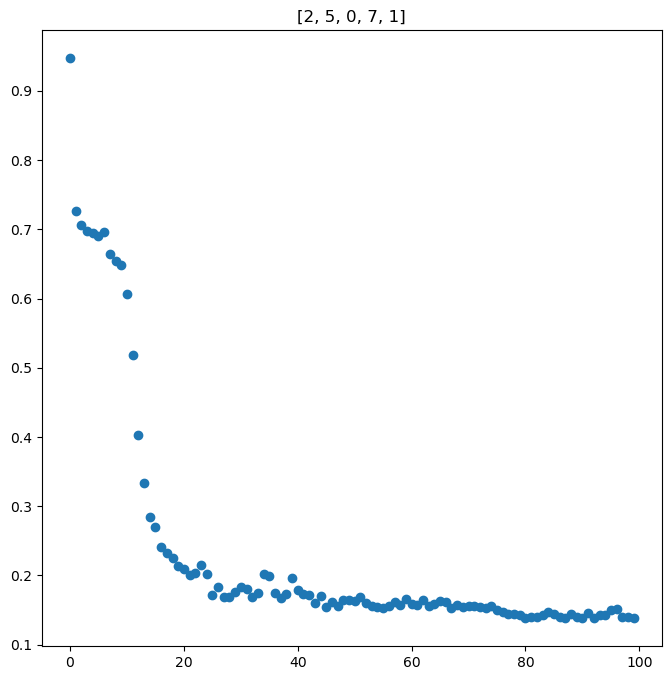

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081   0.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335   0.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978   0.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393   0.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074   0.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 1.4292835097678993
loss_and_grads loss: 1.4292835097678993


/Users/admin/Desktop/phy_329/ssm/helpers.py:4: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
baseline constant-p loss: 2.4408682028173887
1.7385621805002924
0.73


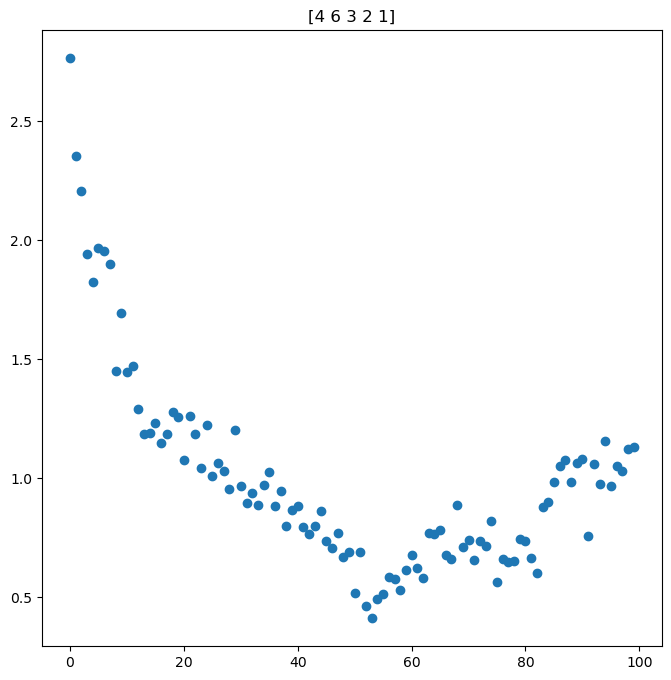

[[  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081   0.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978   0.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
    0.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074   0.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.34801485708940044
loss_and_grads loss: 0.34801485708940044
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all 

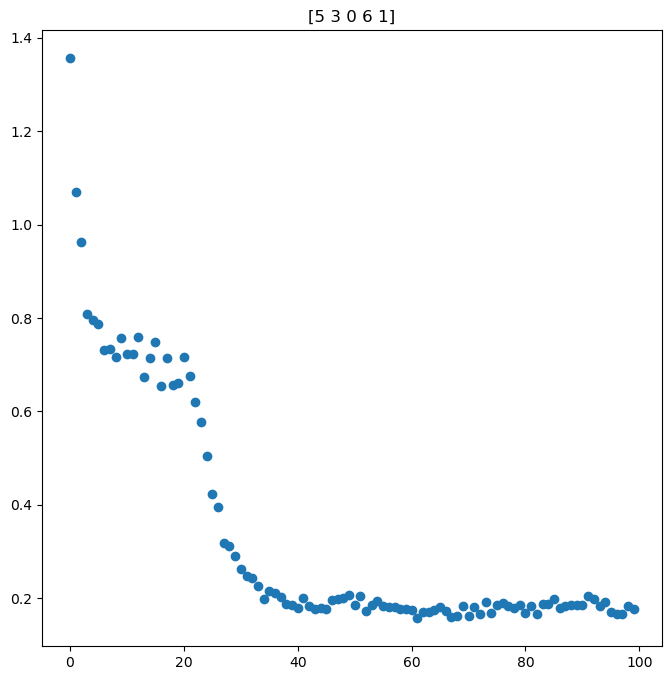

[[  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081   0.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335   0.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978   0.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004   0.        ]]
manual BCE on first sequence: 2.6952585959463295
loss_and_grads loss: 2.6952585959463295
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

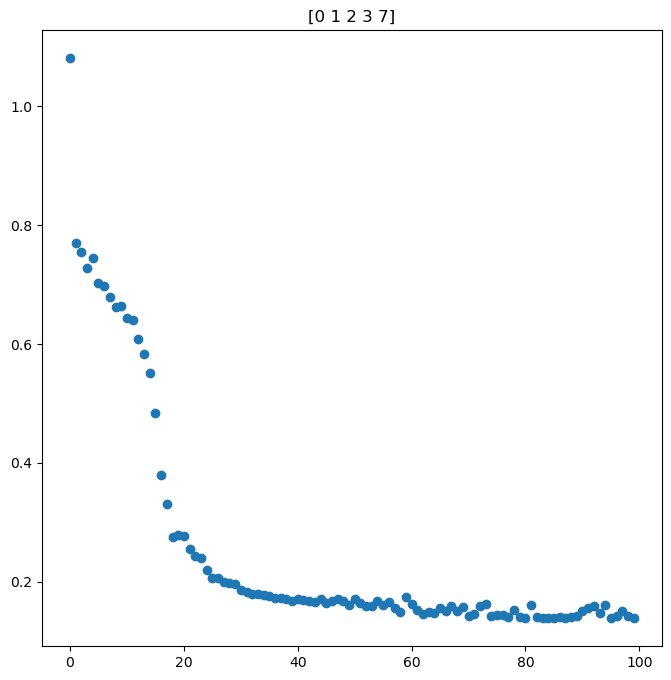

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335   0.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978   0.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
    0.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074   0.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004   0.        ]]
manual BCE on first sequence: 11.184068497338611
loss_and_grads loss: 11.184068497338611
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

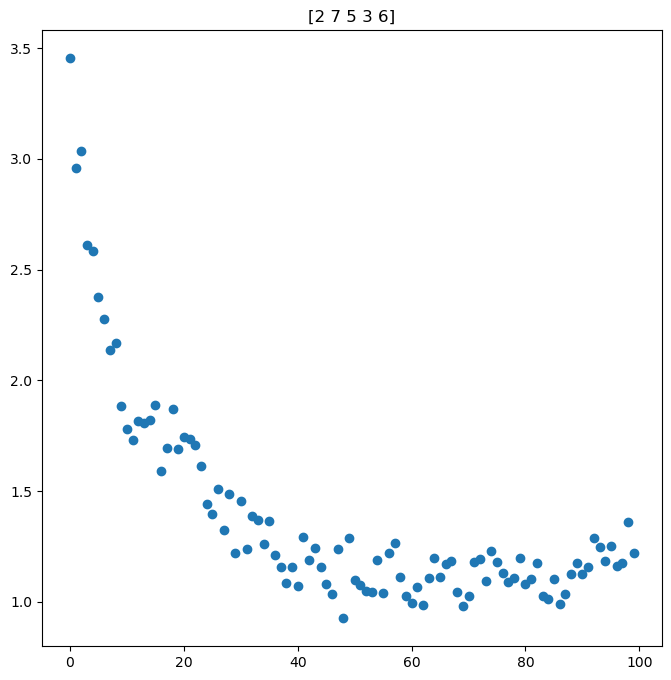

[[  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335   0.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978   0.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393   0.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
    0.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 2.4150038947946375
loss_and_grads loss: 2.4150038947946375
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

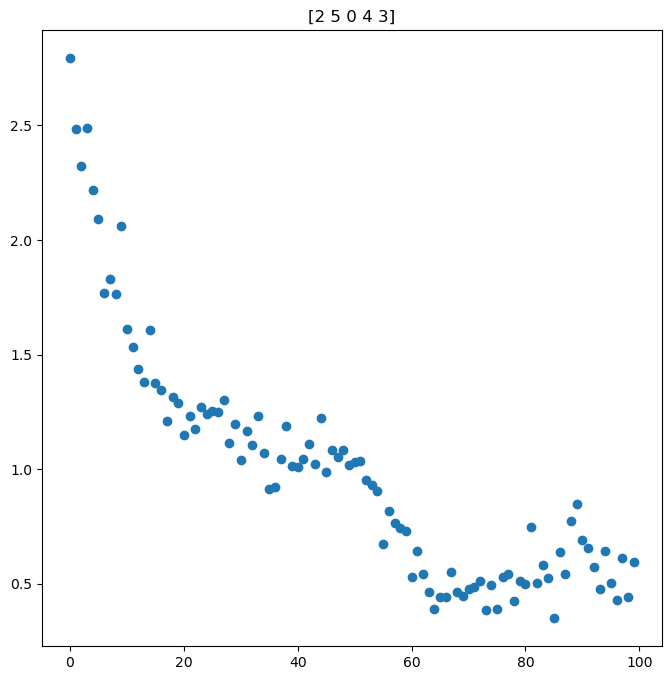

[[  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335   0.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978   0.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393   0.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004   0.        ]]
manual BCE on first sequence: 9.052142298529693
loss_and_grads loss: 9.052142298529693
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all trai

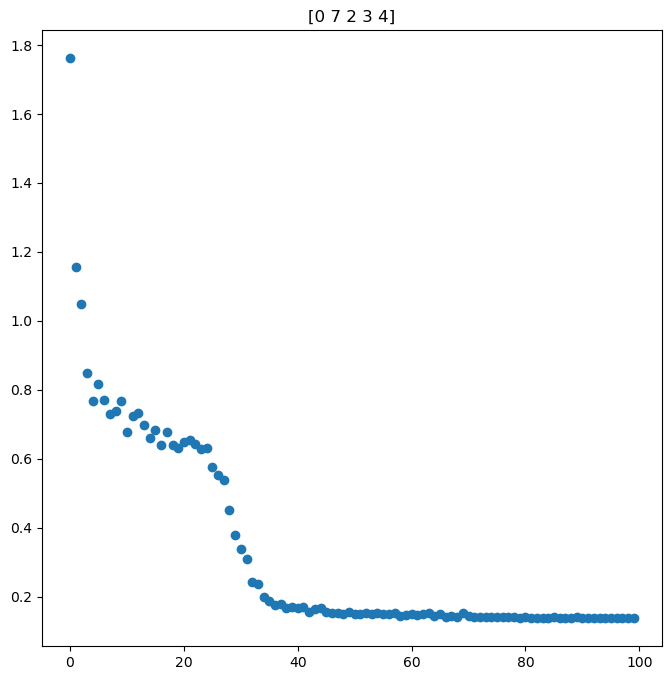

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335   0.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978   0.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393   0.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
    0.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004   0.        ]]
manual BCE on first sequence: 11.201112249737225
loss_and_grads loss: 11.201112249737225
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

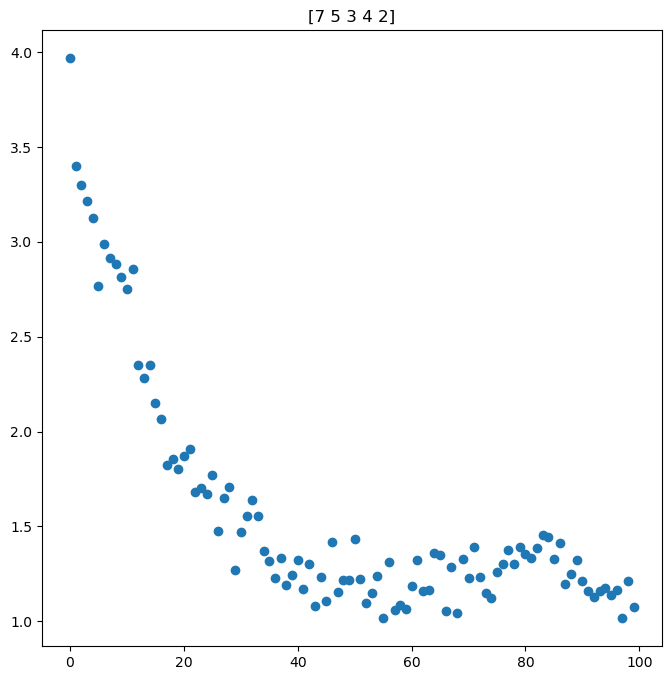

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081   0.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978   0.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393   0.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074   0.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004   0.        ]]
manual BCE on first sequence: 11.207258437222716
loss_and_grads loss: 11.207258437222716
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

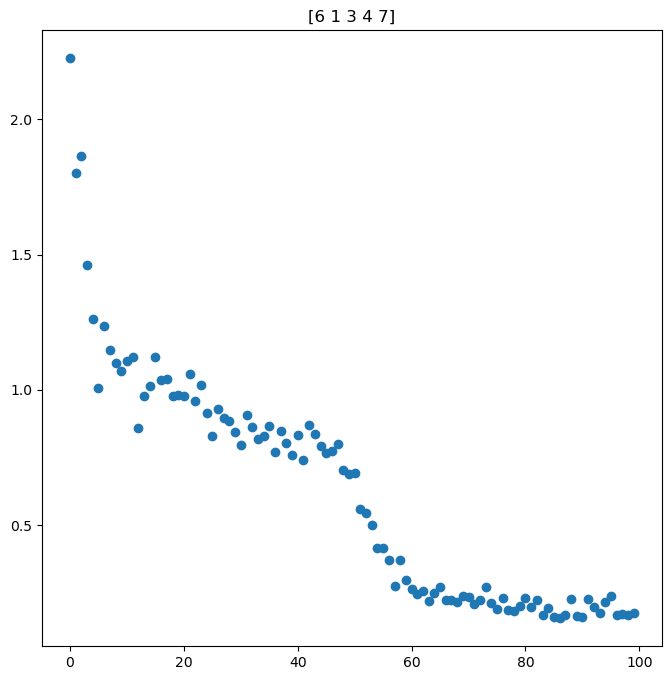

[[  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081   0.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393   0.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074   0.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004   0.        ]]
manual BCE on first sequence: 6.905448650352874
loss_and_grads loss: 6.905448650352874
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all trai

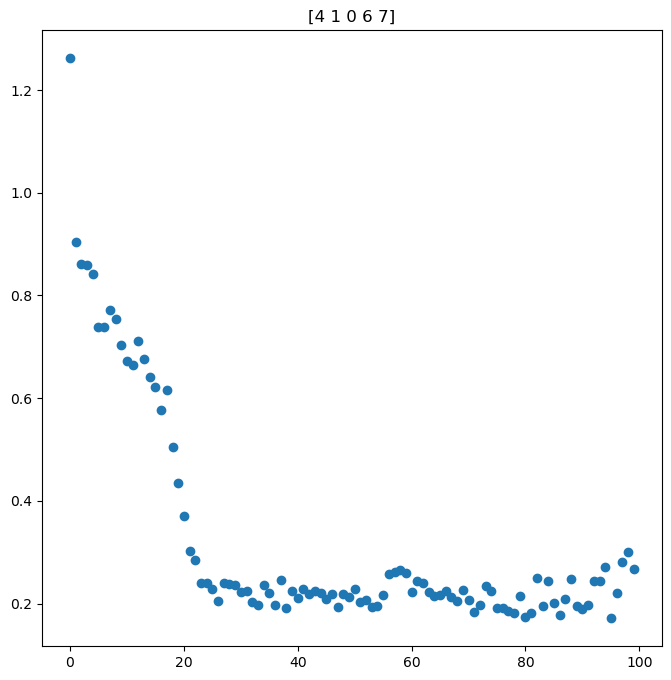

[[  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978   0.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
    0.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074   0.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004   0.        ]]
manual BCE on first sequence: 11.270372011271132
loss_and_grads loss: 11.270372011271132
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

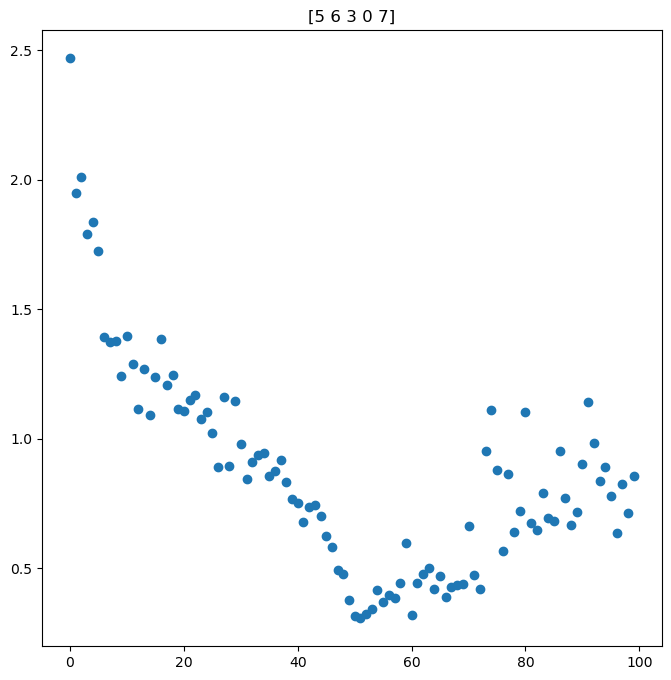

In [14]:



for j in range(1):
    plt.figure(figsize = (8,8))
    model = SimpleSSM(state_dim=8, input_dim=1, output_dim=1)
    chosen_numbers = [2,5,0,7,1]
    model.A_ct[5][5] = 0
    model.A_ct[2][2] = 0
    model.A_ct[0][0] = 0
    model.A_ct[7][7] = 0
    model.A_ct[1][1] = 0
    #model.A_ct[5][5] = 0 still maintains some stability
    #while model.A_ct[2][2] = 0 already makes things crumble
    
    print(model.A_ct)
    model.A = discretize_bilinear(model.A_ct, dt=model.dt)
    
    u = x_train[0]            # (T,1)
    t = y_train[0]            # (T,1)
    logits, _ = model.forward(u)
    #print(logits)
    probs = sigmoid(logits)

    eps = 1e-8
    loss_manual = -np.mean(
        t * np.log(probs + eps) +
        (1 - t) * np.log(1 - probs + eps)
    )
    print("manual BCE on first sequence:", loss_manual)

    loss, _ = model.loss_and_grads(u, t)
    print("loss_and_grads loss:", loss)


    los = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i in range(x_train.shape[0]):
            u = x_train[i]      # shape (T,1)
            tgt = y_train[i]    # shape (T,1)

            loss, grads = model.loss_and_grads(u, tgt)
        

        
            model.step(grads, lr=learning_rate)
            epoch_loss += loss
        los.append(epoch_loss / x_train.shape[0])
        #print(f"epoch {epoch} | avg loss = {epoch_loss / x_train.shape[0]}")

    # Testing ERror
    print("mean of y_train:", y_train.mean())
    print("min target:", y_train.min(), "max target:", y_train.max())
    print("mean target over all train data:", y_train.mean())

    u = x_train[0].reshape(-1)
    t = y_train[0].reshape(-1)
    print("input:  ", u.astype(int).tolist())
    print("target: ", t.astype(int).tolist())


    eps = 1e-8
    p = 0.01
    y = y_train.reshape(-1)   # flatten all targets

    baseline_loss = -np.mean(
        y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)
    )

    print("baseline constant-p loss:", baseline_loss)





    N = x_test.shape[0]
    total_loss = 0.0
    total_correct = 0
    total_bits = 0

    for i in range(N):
        u = x_test[i]      # (T, 1)
        tgt = y_test[i]    # (T, 1)

        # forward pass only (no grads)
        logits, _ = model.forward(u)

        # loss for this sequence
        loss = binary_cross_entropy(logits, tgt)
        total_loss += loss

        # compute accuracy for this sequence
        probs = sigmoid(logits)
        preds = (probs > 0.5).astype(int)   # threshold at 0.5
        total_correct += (preds == tgt).sum()
        total_bits += tgt.size

    avg_loss = total_loss / N
    accuracy = total_correct / total_bits

    print(avg_loss)
    print(accuracy)
    plt.scatter([i for i in range(num_epochs)], los)
    plt.title(f'{chosen_numbers}')


   
    plt.show()


for j in range(10):
    plt.figure(figsize = (8,8))
    model = SimpleSSM(state_dim=8, input_dim=1, output_dim=1)
    chosen_numbers = np.random.choice([0,1,2,3,4,5,6,7], size=5, replace=False)
    for z in chosen_numbers:
        model.A_ct[z][z] = 0
    #model.A_ct[5][5] = 0 still maintains some stability
    #while model.A_ct[2][2] = 0 already makes things crumble
    
    print(model.A_ct)
    model.A = discretize_bilinear(model.A_ct, dt=model.dt)
    
    u = x_train[0]            # (T,1)
    t = y_train[0]            # (T,1)
    logits, _ = model.forward(u)
    #print(logits)
    probs = sigmoid(logits)

    eps = 1e-8
    loss_manual = -np.mean(
        t * np.log(probs + eps) +
        (1 - t) * np.log(1 - probs + eps)
    )
    print("manual BCE on first sequence:", loss_manual)

    loss, _ = model.loss_and_grads(u, t)
    print("loss_and_grads loss:", loss)


    los = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i in range(x_train.shape[0]):
            u = x_train[i]      # shape (T,1)
            tgt = y_train[i]    # shape (T,1)

            loss, grads = model.loss_and_grads(u, tgt)
        

        
            model.step(grads, lr=learning_rate)
            epoch_loss += loss
        los.append(epoch_loss / x_train.shape[0])
        #print(f"epoch {epoch} | avg loss = {epoch_loss / x_train.shape[0]}")

    # Testing ERror
    print("mean of y_train:", y_train.mean())
    print("min target:", y_train.min(), "max target:", y_train.max())
    print("mean target over all train data:", y_train.mean())

    u = x_train[0].reshape(-1)
    t = y_train[0].reshape(-1)
    print("input:  ", u.astype(int).tolist())
    print("target: ", t.astype(int).tolist())


    eps = 1e-8
    p = 0.01
    y = y_train.reshape(-1)   # flatten all targets

    baseline_loss = -np.mean(
        y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)
    )

    print("baseline constant-p loss:", baseline_loss)





    N = x_test.shape[0]
    total_loss = 0.0
    total_correct = 0
    total_bits = 0

    for i in range(N):
        u = x_test[i]      # (T, 1)
        tgt = y_test[i]    # (T, 1)

        # forward pass only (no grads)
        logits, _ = model.forward(u)

        # loss for this sequence
        loss = binary_cross_entropy(logits, tgt)
        total_loss += loss

        # compute accuracy for this sequence
        probs = sigmoid(logits)
        preds = (probs > 0.5).astype(int)   # threshold at 0.5
        total_correct += (preds == tgt).sum()
        total_bits += tgt.size

    avg_loss = total_loss / N
    accuracy = total_correct / total_bits

    print(avg_loss)
    print(accuracy)
    plt.scatter([i for i in range(num_epochs)], los)
    plt.title(f'{chosen_numbers}')


   
    plt.show()

[[  0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.6929511059046828
loss_and_grads loss: 0.6929511059046828
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

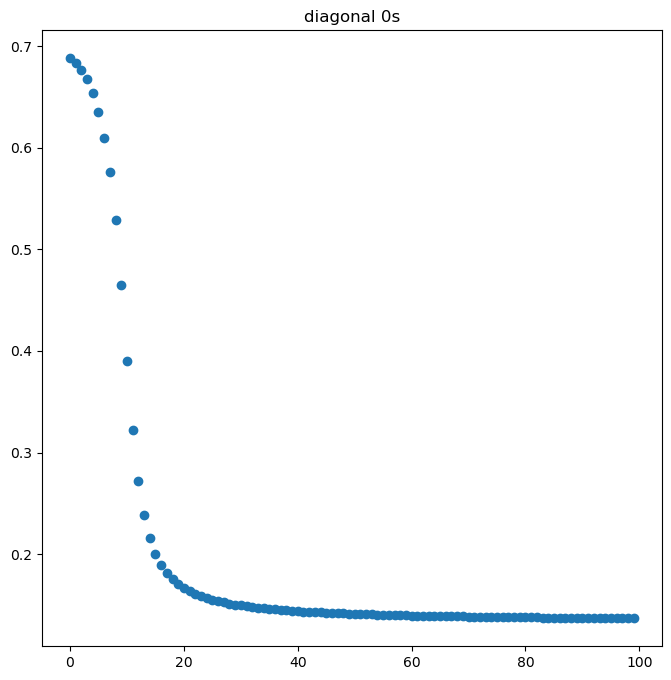

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081   0.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.690474720416374
loss_and_grads loss: 0.690474720416374
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all trai

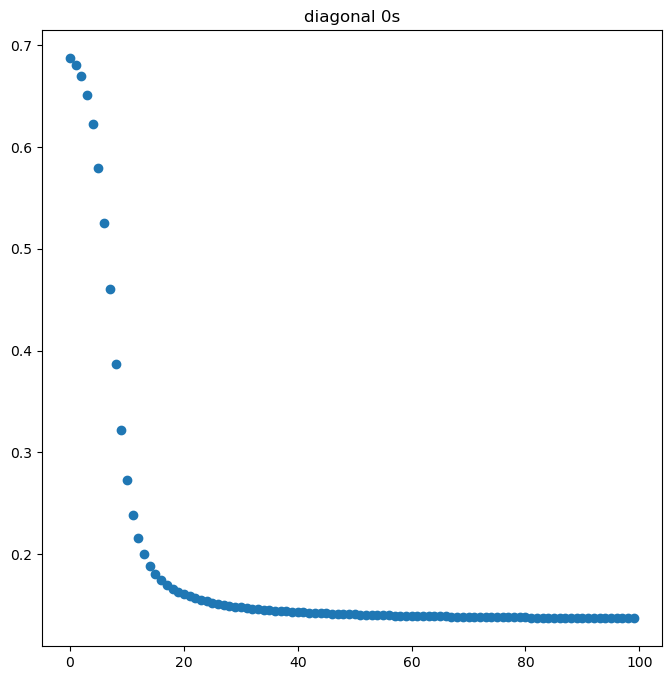

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335   0.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.6701974365561123
loss_and_grads loss: 0.6701974365561123
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

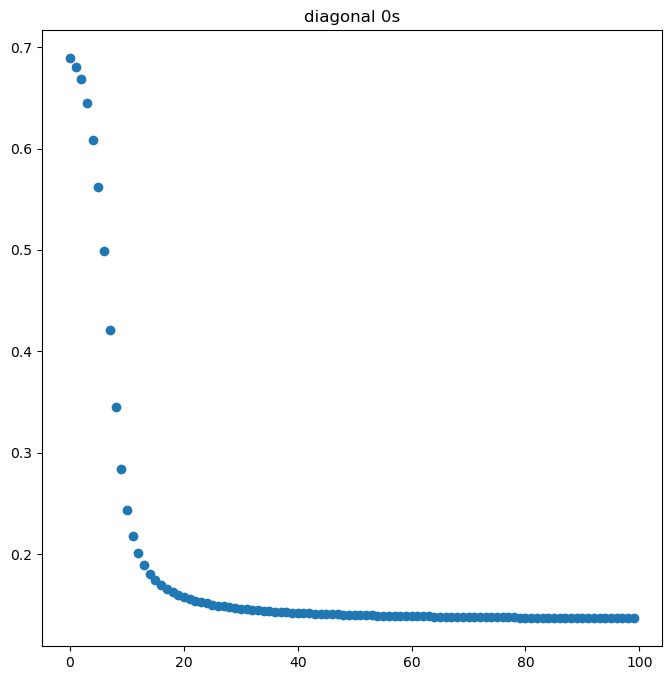

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978   0.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.6548355225939554
loss_and_grads loss: 0.6548355225939554
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

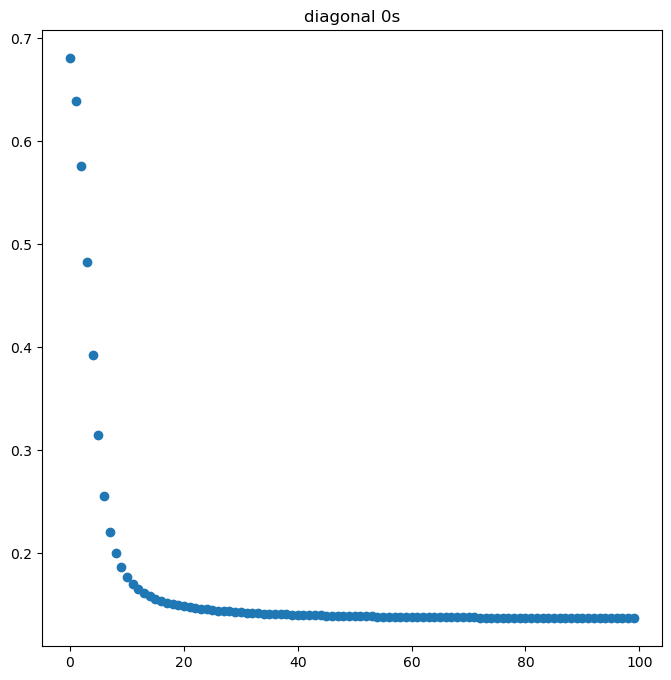

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393   0.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.6780398617051014
loss_and_grads loss: 0.6780398617051014
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

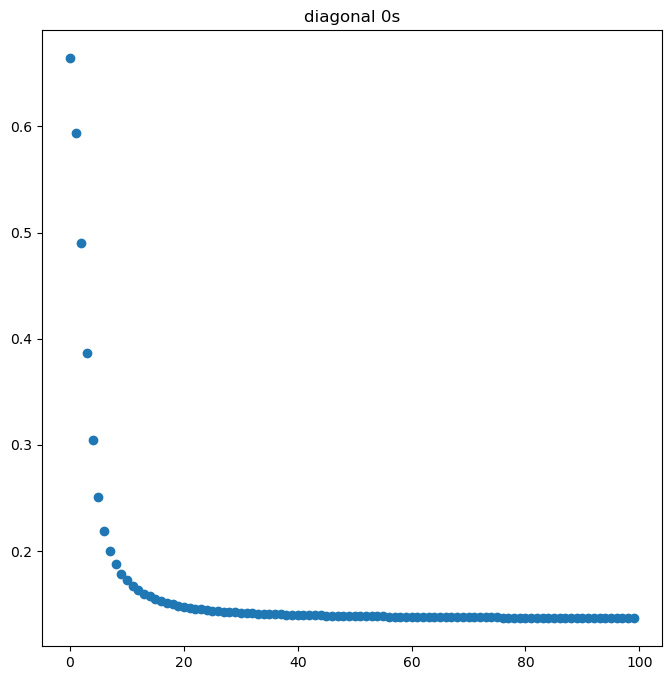

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
    0.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074  -7.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.6932910833913597
loss_and_grads loss: 0.6932910833913597
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

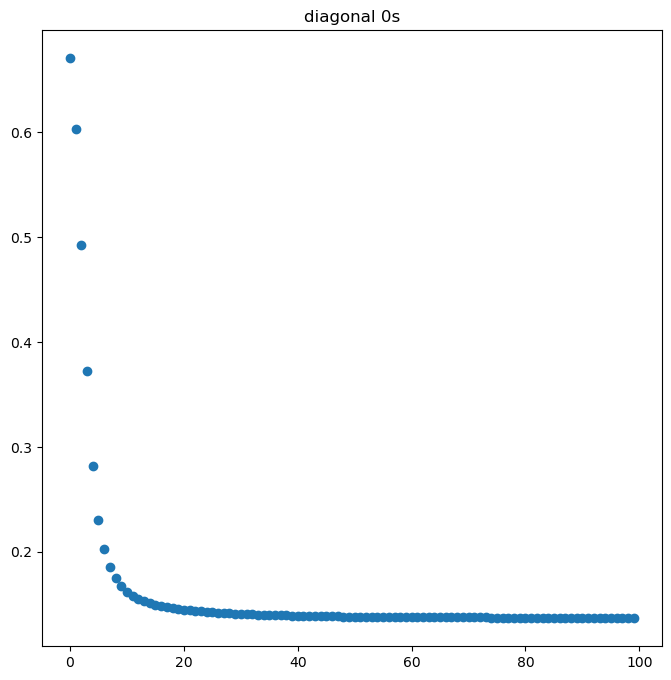

[[ -1.           0.           0.           0.           0.
    0.           0.           0.        ]
 [ -1.73205081  -2.           0.           0.           0.
    0.           0.           0.        ]
 [ -2.23606798  -3.87298335  -3.           0.           0.
    0.           0.           0.        ]
 [ -2.64575131  -4.58257569  -5.91607978  -4.           0.
    0.           0.           0.        ]
 [ -3.          -5.19615242  -6.70820393  -7.93725393  -5.
    0.           0.           0.        ]
 [ -3.31662479  -5.74456265  -7.41619849  -8.77496439  -9.94987437
   -6.           0.           0.        ]
 [ -3.60555128  -6.244998    -8.06225775  -9.53939201 -10.81665383
  -11.95826074   0.           0.        ]
 [ -3.87298335  -6.70820393  -8.66025404 -10.24695077 -11.61895004
  -12.84523258 -13.96424004  -8.        ]]
manual BCE on first sequence: 0.6933602086726343
loss_and_grads loss: 0.6933602086726343
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all tr

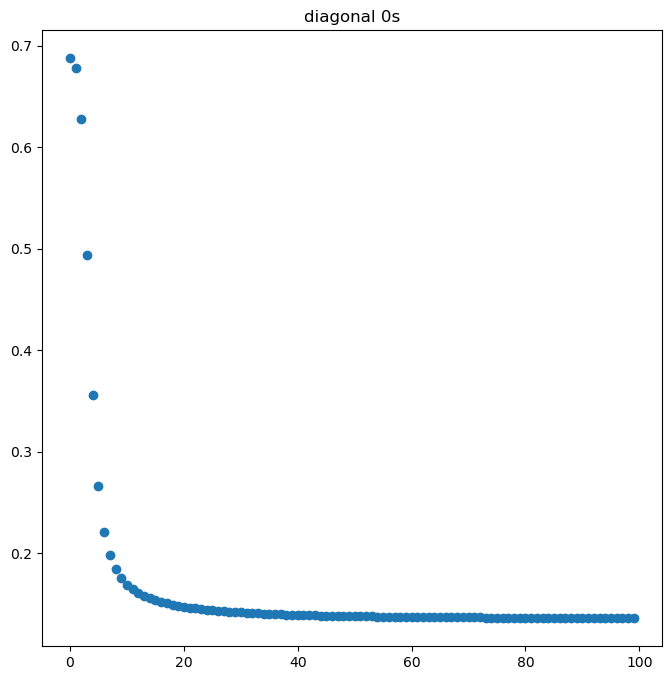

In [106]:



for j in range(7):
    plt.figure(figsize = (8,8))
    model = SimpleSSM(state_dim=8, input_dim=1, output_dim=1)
    model.A_ct[0+j][0+j] = 0
    
    print(model.A_ct)
    model.A = discretize_bilinear(model.A_ct, dt=model.dt)

    u = x_train[0]            # (T,1)
    t = y_train[0]            # (T,1)
    logits, _ = model.forward(u)
    #print(logits)
    probs = sigmoid(logits)

    eps = 1e-8
    loss_manual = -np.mean(
        t * np.log(probs + eps) +
        (1 - t) * np.log(1 - probs + eps)
    )
    print("manual BCE on first sequence:", loss_manual)

    loss, _ = model.loss_and_grads(u, t)
    print("loss_and_grads loss:", loss)


    los = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i in range(x_train.shape[0]):
            u = x_train[i]      # shape (T,1)
            tgt = y_train[i]    # shape (T,1)

            loss, grads = model.loss_and_grads(u, tgt)
        

        
            model.step(grads, lr=learning_rate)
            epoch_loss += loss
        los.append(epoch_loss / x_train.shape[0])
        #print(f"epoch {epoch} | avg loss = {epoch_loss / x_train.shape[0]}")

    # Testing ERror
    print("mean of y_train:", y_train.mean())
    print("min target:", y_train.min(), "max target:", y_train.max())
    print("mean target over all train data:", y_train.mean())

    u = x_train[0].reshape(-1)
    t = y_train[0].reshape(-1)
    print("input:  ", u.astype(int).tolist())
    print("target: ", t.astype(int).tolist())


    eps = 1e-8
    p = 0.01
    y = y_train.reshape(-1)   # flatten all targets

    baseline_loss = -np.mean(
        y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)
    )

    print("baseline constant-p loss:", baseline_loss)





    N = x_test.shape[0]
    total_loss = 0.0
    total_correct = 0
    total_bits = 0

    for i in range(N):
        u = x_test[i]      # (T, 1)
        tgt = y_test[i]    # (T, 1)

        # forward pass only (no grads)
        logits, _ = model.forward(u)

        # loss for this sequence
        loss = binary_cross_entropy(logits, tgt)
        total_loss += loss

        # compute accuracy for this sequence
        probs = sigmoid(logits)
        preds = (probs > 0.5).astype(int)   # threshold at 0.5
        total_correct += (preds == tgt).sum()
        total_bits += tgt.size

    avg_loss = total_loss / N
    accuracy = total_correct / total_bits

    print(avg_loss)
    print(accuracy)
    plt.scatter([i for i in range(num_epochs)], los)
    plt.title(f'diagonal 0s')


   
    plt.show()

[[0.52735122 0.15495854 0.71705461 0.20632655 0.11727636 0.5466928
  0.84521571 0.32104655]
 [0.8125653  0.13829496 0.71916576 0.56059936 0.20413109 0.22770666
  0.12771176 0.73513278]
 [0.19042766 0.90703585 0.59932815 0.04441199 0.63468863 0.05439727
  0.82755934 0.42057181]
 [0.43819324 0.33635372 0.62455269 0.25184466 0.26035469 0.80688424
  0.37303019 0.79998854]
 [0.95687257 0.33151368 0.3416863  0.33409702 0.16150924 0.26269251
  0.22200235 0.76647679]
 [0.39035664 0.96055845 0.81528856 0.19265855 0.62519251 0.83799553
  0.1724382  0.64765947]
 [0.88691231 0.43982506 0.96980894 0.969388   0.34671867 0.1821946
  0.20970734 0.59744188]
 [0.41332307 0.03704714 0.72396242 0.61301644 0.94443547 0.63221623
  0.24124236 0.48314742]]
manual BCE on first sequence: 4.559443885698011
loss_and_grads loss: 4.559443885698011
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0, 0,

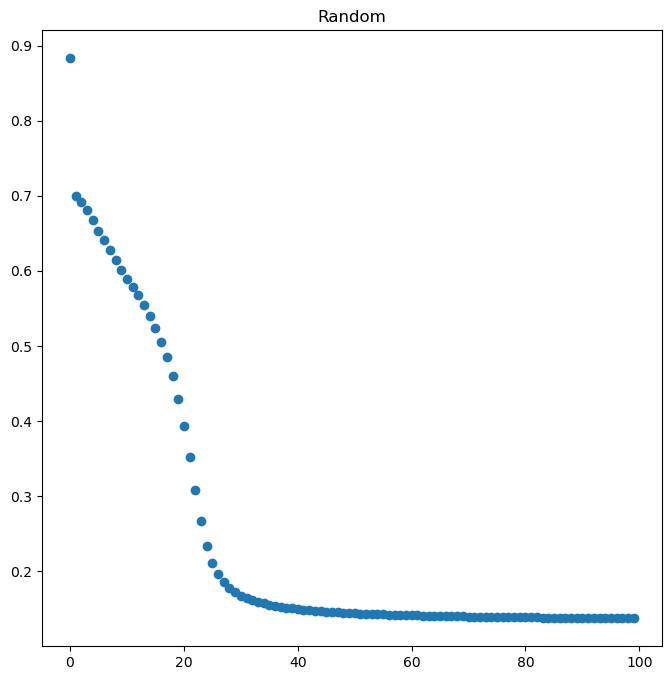

[[0.0183533  0.83130327 0.19526982 0.9952022  0.82712272 0.36966247
  0.97759876 0.59244531]
 [0.66807118 0.28904701 0.90976916 0.91577275 0.59476779 0.87243395
  0.43873811 0.12698076]
 [0.57939303 0.71287662 0.53572687 0.48788699 0.24085421 0.05803007
  0.2200292  0.89892349]
 [0.55277904 0.08231663 0.32989544 0.5498199  0.98901264 0.36451554
  0.7896317  0.38093953]
 [0.72526166 0.25579204 0.22620666 0.16863395 0.50125828 0.17970758
  0.58416971 0.11100511]
 [0.07066845 0.90006196 0.48702521 0.79051119 0.74241267 0.77608892
  0.15639556 0.27102247]
 [0.29385087 0.78919537 0.54351555 0.23337086 0.64845738 0.04755467
  0.24733996 0.47588696]
 [0.56363267 0.71421168 0.39576235 0.68597153 0.73235637 0.51631911
  0.67706686 0.85365803]]
manual BCE on first sequence: 4.341453265270481
loss_and_grads loss: 4.341453265270481
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0, 

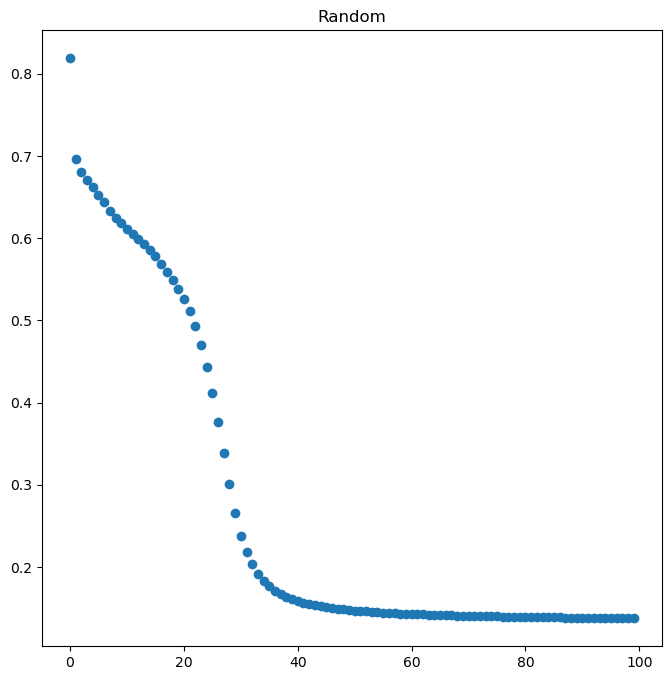

[[0.835002   0.46394935 0.99968514 0.85312432 0.63408988 0.65425491
  0.19220648 0.17030658]
 [0.87670185 0.36930267 0.95804658 0.83139288 0.93535269 0.96765332
  0.64622701 0.44864644]
 [0.37919876 0.40487263 0.14670996 0.31470899 0.53536721 0.07073751
  0.48653326 0.93380435]
 [0.47878562 0.1083771  0.36955133 0.79279168 0.90533646 0.92662662
  0.06425218 0.308636  ]
 [0.01410227 0.78060582 0.43052964 0.46928503 0.22581361 0.24294389
  0.43302519 0.0547173 ]
 [0.38246242 0.17792342 0.07668549 0.94988319 0.08803372 0.45852872
  0.86528669 0.33881002]
 [0.25313036 0.15137188 0.94226438 0.39603006 0.24351087 0.3971737
  0.89476698 0.50677629]
 [0.09761073 0.84409609 0.44155737 0.16965306 0.02690966 0.02902538
  0.720474   0.91566802]]
manual BCE on first sequence: 4.456660762869204
loss_and_grads loss: 4.456660762869204
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0, 0

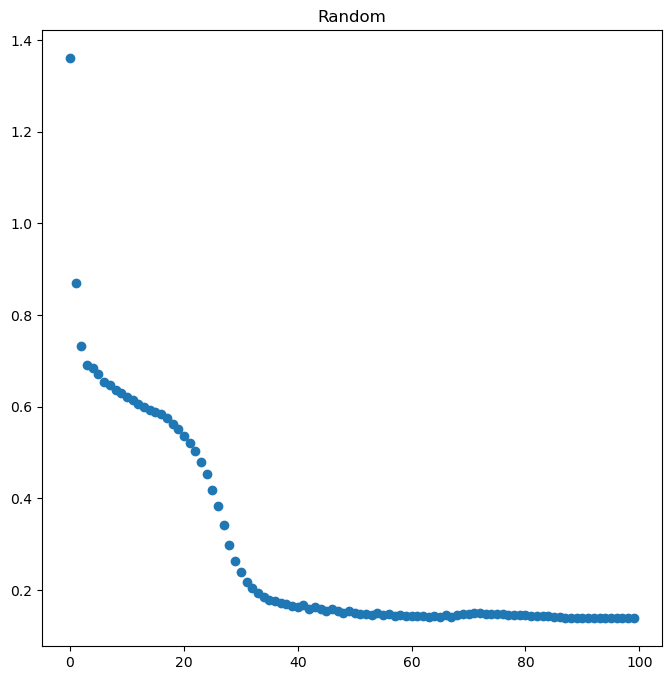

[[0.63852135 0.26642142 0.4487001  0.26016092 0.57871007 0.25157292
  0.26250249 0.42573329]
 [0.94048819 0.62141237 0.81781549 0.73407041 0.43210424 0.98987041
  0.89671272 0.31549878]
 [0.02188767 0.80118556 0.95798689 0.42130485 0.15006518 0.55318715
  0.42313208 0.17620831]
 [0.89187247 0.46292621 0.16834459 0.35834829 0.40798785 0.94364475
  0.13214037 0.40606912]
 [0.62074932 0.8965154  0.37198383 0.4803096  0.8880618  0.99264373
  0.13687834 0.09180563]
 [0.50761146 0.18055405 0.47027555 0.23371744 0.32958055 0.10373058
  0.88827954 0.93110495]
 [0.29633414 0.32615315 0.72434004 0.4033979  0.54944096 0.30292353
  0.28413319 0.54394064]
 [0.96360273 0.91866565 0.75613583 0.31156385 0.54082448 0.3070817
  0.39303598 0.19454493]]
manual BCE on first sequence: 4.516904769981427
loss_and_grads loss: 4.516904769981427
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0, 0

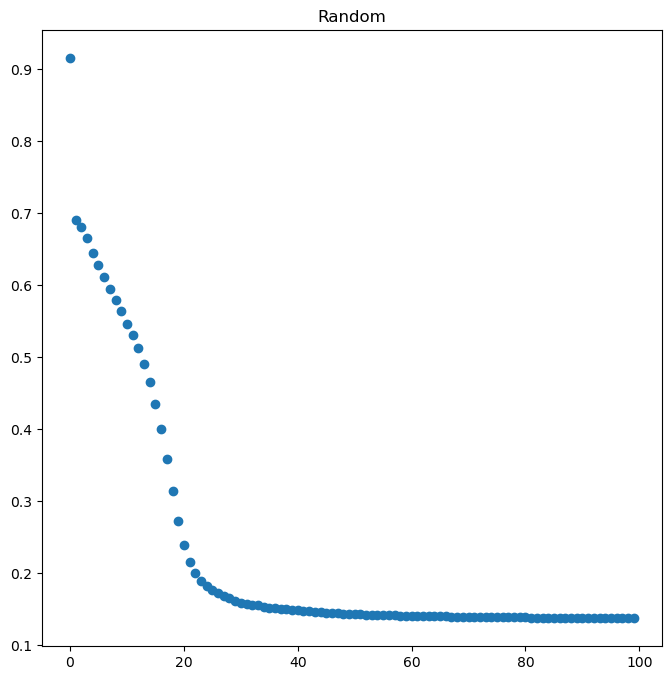

[[0.0157136  0.9406965  0.94282375 0.39851329 0.51451868 0.0706375
  0.81253605 0.96287396]
 [0.87463522 0.82723629 0.81286933 0.91036246 0.55162892 0.69732223
  0.65599432 0.23502385]
 [0.07198453 0.92574531 0.11580868 0.63238917 0.46664496 0.28742481
  0.35063892 0.50651961]
 [0.86295457 0.34720981 0.04458201 0.93919025 0.26758887 0.5847197
  0.4955149  0.2851682 ]
 [0.95016571 0.28077981 0.33103535 0.6305349  0.44597391 0.70542277
  0.65733519 0.69311475]
 [0.52433323 0.76747296 0.44116382 0.89058153 0.52007338 0.81619572
  0.27146429 0.21222204]
 [0.04232123 0.49898189 0.39541592 0.5874554  0.11975813 0.36250939
  0.70677225 0.44269304]
 [0.44482566 0.28622245 0.90196026 0.30538612 0.03782952 0.18128506
  0.29980014 0.87651481]]
manual BCE on first sequence: 4.338556692450666
loss_and_grads loss: 4.338556692450666
mean of y_train: 0.529
min target: 0.0 max target: 1.0
mean target over all train data: 0.529
input:   [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
target:  [1, 1, 1, 1, 0, 0, 0, 0, 0,

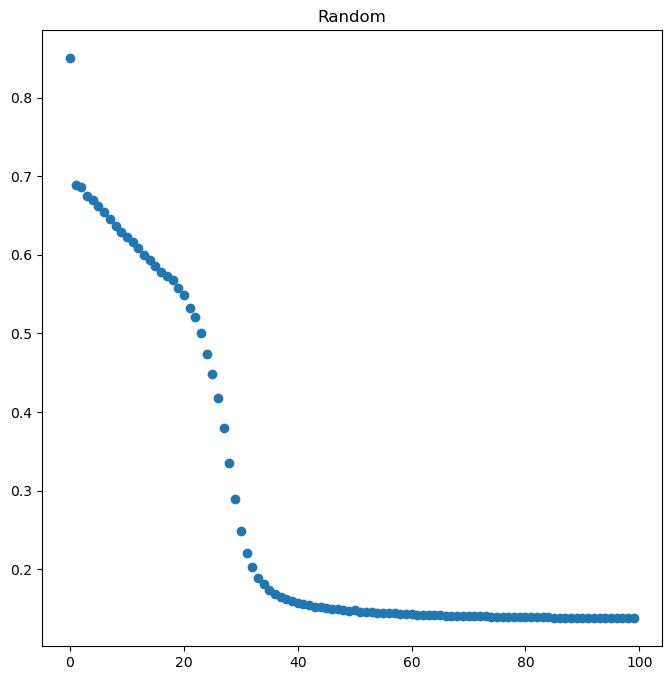

In [31]:



for j in range(5):
    plt.figure(figsize = (8,8))
    model = SimpleSSM(state_dim=8, input_dim=1, output_dim=1)
    model.A_ct = np.random.rand(model.A_ct.shape[0], model.A_ct.shape[1])
    
    print(model.A_ct)
    model.A = discretize_bilinear(model.A_ct, dt=model.dt)

    u = x_train[0]            # (T,1)
    t = y_train[0]            # (T,1)
    logits, _ = model.forward(u)
    #print(logits)
    probs = sigmoid(logits)

    eps = 1e-8
    loss_manual = -np.mean(
        t * np.log(probs + eps) +
        (1 - t) * np.log(1 - probs + eps)
    )
    print("manual BCE on first sequence:", loss_manual)

    loss, _ = model.loss_and_grads(u, t)
    print("loss_and_grads loss:", loss)


    los = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i in range(x_train.shape[0]):
            u = x_train[i]      # shape (T,1)
            tgt = y_train[i]    # shape (T,1)

            loss, grads = model.loss_and_grads(u, tgt)
        

        
            model.step(grads, lr=learning_rate)
            epoch_loss += loss
        los.append(epoch_loss / x_train.shape[0])
        #print(f"epoch {epoch} | avg loss = {epoch_loss / x_train.shape[0]}")

    # Testing ERror
    print("mean of y_train:", y_train.mean())
    print("min target:", y_train.min(), "max target:", y_train.max())
    print("mean target over all train data:", y_train.mean())

    u = x_train[0].reshape(-1)
    t = y_train[0].reshape(-1)
    print("input:  ", u.astype(int).tolist())
    print("target: ", t.astype(int).tolist())


    eps = 1e-8
    p = 0.01
    y = y_train.reshape(-1)   # flatten all targets

    baseline_loss = -np.mean(
        y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)
    )

    print("baseline constant-p loss:", baseline_loss)





    N = x_test.shape[0]
    total_loss = 0.0
    total_correct = 0
    total_bits = 0

    for i in range(N):
        u = x_test[i]      # (T, 1)
        tgt = y_test[i]    # (T, 1)

        # forward pass only (no grads)
        logits, _ = model.forward(u)

        # loss for this sequence
        loss = binary_cross_entropy(logits, tgt)
        total_loss += loss

        # compute accuracy for this sequence
        probs = sigmoid(logits)
        preds = (probs > 0.5).astype(int)   # threshold at 0.5
        total_correct += (preds == tgt).sum()
        total_bits += tgt.size

    avg_loss = total_loss / N
    accuracy = total_correct / total_bits

    print(avg_loss)
    print(accuracy)
    plt.scatter([i for i in range(num_epochs)], los)
    plt.title(f'Random')


   
    plt.show()